In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import datetime
import math
from scipy import linalg as LA

In [286]:
def pre_process(text):
    # Pre-process text which includes: (1) removing uppercase letters, (2) remove tags and 
    # (3) removing special characters and digits
    
    # lowercase
    text=text.lower()
    
    # remove tags
    text=re.sub("</?.*?>", " <> ", text)
    
    # remove special characters and digits
    text=re.sub("(\\d|\\W)+"," ", text)
        
    return text

In [15]:
def get_stop_words(stop_file_path):
    # From a txt file, get a stopword list
    
    with open(stop_file_path, 'r', encoding="utf-8") as f:
        # Read each line
        stopwords = f.readlines()
        # Save each single word in stop_set set
        stop_set = set(m.strip() for m in stopwords)
        return frozenset(stop_set)

In [77]:
def get_dataframe(file_path):
    # From .json file, return the database
    return pd.read_json(file_path, lines=True)

In [78]:
def combine_two_dataframes(df1, df2, fields):
    # Combine two dataframes with no duplicates, and only for the specified fields (columns)
    
    # Only use the specified fields for the databases
    df1=df1[fields]
    df2=df2[fields]
    
    # Return combined dataframe with no duplicates, and give new updated indexes
    return pd.concat([df1,df2]).drop_duplicates().reset_index(drop=True)

In [276]:
def get_tweet_count_plots(df, date, dif_month, nr_top_words, stopwords, hashtags):
    # Return dataframe from the before period dif_months before, and a dataframe from the after periods with dif_months after.
    # Also return the text from these dataframes, and the the word count from both periods.
    
    # Convert given request date in datetime 
    dt = np.datetime64(date)
    
    # Convert the given dif_month in a amount of days. For this calculation, an average of 30 days per month is used
    dif_time = np.timedelta64(dif_month*30, 'D')
    
    # Return list for each date of the tweets
    time = df['created_at'].tolist()
    
    # Make two new databases given the difference in time and preprocess their text.
    df_before = df[(time<=dt) & (time>=(dt-dif_time))].reset_index(drop=True)
    df_after = df[(time>dt) & (time<=(dt+dif_time))].reset_index(drop=True)
    df_before['text'] = df_before['text'].apply(lambda x: pre_process(x))
    df_after['text'] = df_after['text'].apply(lambda x: pre_process(x))
    
    # Safe the preprocessed text
    docs_before = df_before['text']
    docs_after = df_after['text']
    
    # Split sentences in words for both string arrays
    words_before = [word for line in docs_before for word in line.split()]
    words_after = [word for line in docs_after for word in line.split()]

    # Remove stopwords using stopword textfile from both word arrays
    words_no_stopwords_before = [i for i in words_before if i not in stopwords]
    words_no_stopwords_after = [i for i in words_after if i not in stopwords]

    # Give count of each word in array
    values_before = pd.value_counts(np.array(words_no_stopwords_before))
    values_after = pd.value_counts(np.array(words_no_stopwords_after))

    # Transform into list
    values_list_before = values_before.tolist()
    values_list_after = values_after.tolist()
    
    # Plot count figure
    f = plt.figure()
    fig, axs = plt.subplots(1,2, constrained_layout = True)
    fig.set_figheight(20)
    
    # Plot word count barplot that shows the nr_top_words of the top words from the before and after period
    bar_before = axs[0].barh(values_before.keys()[0:nr_top_words], values_list_before[0:nr_top_words])
    axs[0].bar_label(bar_before)
    axs[0].set_xlabel('Count')
    axs[0].set_ylabel('Top used words')
    axs[0].set_title('6 months before WOB request')
    bar_after = axs[1].barh(values_after.keys()[0:nr_top_words], values_list_after[0:nr_top_words], label=values_list_after[0:nr_top_words])
    axs[1].bar_label(bar_after)
    axs[1].set_xlabel('Count')
    axs[1].set_ylabel('Top used words')
    axs[1].set_title('6 months after WOB request')
    plt.show()
    
    # Plot tweet count from 2011-2019
    my_dict = {i.date():time.count(i.date()) for i in time}
    x,y = zip(*my_dict.items())
    plt.figure(figsize= (40,10))
    plt.bar(x,y, label ='Count per day')
    # Plot a red line that depicts the date of the Wob request
    plt.plot((dt, dt),(-10,1000), label ='date Wob request', color='r')
    plt.title('Amount of tweets that use hashtag {} per day from 2011 - 2019'.format(hashtags))
    plt.xlabel('Date')
    plt.ylabel('Count per day')
    plt.legend()
    plt.ylim([0, max(y)+10])
    plt.show()
    
    # Return the calculated dataframes and lists
    return df_before, df_after, docs_before, docs_after, values_before, values_after

In [17]:
def get_word_count(df, docs, values, nr_top_words, nr_first_word):
    # Return word count from nr_first_word with a length of nr_top_words
    words = pd.DataFrame([[0]*nr_top_words], index=df['created_at'], columns=values.keys()[nr_first_word:nr_first_word+nr_top_words])
    for nr_word in range(nr_top_words):
        for t in range(len(df)):
            time = df['created_at'][t]
            word = values.keys()[nr_word+nr_first_word]
            words.at[time, word] = docs[t].split().count(word)
    return words

In [270]:
def get_word_count_plot(df_before, df_after, docs_before, docs_after, values, nr_top_words, nr_first_word):
    # Plot the word count of given word range per day and per word, return the values from before period, after period and combined
    
    words_before = get_word_count(df_before, docs_before, values, nr_top_words, nr_first_word)
    words_after = get_word_count(df_after, docs_after, values, nr_top_words, nr_first_word)
    
    # Before period
    group_day_before = words_before.groupby(words_before.index.date).sum() # Sum per day
    # Plot word count
    group_day_before.plot(figsize=(20,3))
    plt.ylabel('count per day')
    plt.xlabel('day')
    
    # After period
    group_day_after = words_after.groupby(words_after.index.date).sum() # Sum per day
    # Plot word count
    group_day_after.plot(figsize=(20,3))
    plt.ylabel('count per day')
    plt.xlabel('day')
    
    # Combine both before and after period
    group_day_all = pd.concat([group_day_before, group_day_after])
    # Plot word count
    group_day_all.plot(figsize=(20,50))
    plt.grid()
    plt.ylabel('count per day')
    plt.xlabel('day')
    return group_day_before, group_day_before, group_day_all

In [255]:
def termFrequency(term, tweet):
    # Compute Term frequency of a term in a tweet
    
    # Split tweet in single terms
    normalize_tweet = tweet.split()
    # Compute TF
    return normalize_tweet.count(term.lower()) / float(len(normalize_tweet))


In [256]:
def inverseDocumentFrequency(term, tweets):
    # Compute IDF of a term
    count = 0
    for tweet in tweets:
        if term.lower() in tweet:
            # If the specified term is present in the tweet, add to count
            count += 1 
    if count > 0:
        # Calculate IDF
        return 1.0 + math.log(float(len(tweets))/count)
    else:
        # The term is not present in the tweet, IDF = 1
        return 1.0

In [257]:
def tf_idf(term, tweet, tweets):
    # Calculate TF-IDF of a term in a tweet that is present in dataframe tweets
    tf = termFrequency(term, tweet)
    idf = inverseDocumentFrequency(term, tweets)
    return tf*idf

In [258]:
def generateVectors(query, tweets):
    # Calculate the TF-IDF matrix given the query and database tweets
    
    # Make a empty matrix that has size: amount of words in query x number of tweets
    tf_idf_matrix = np.zeros((len(query.split()), len(tweets)))
    
    # For each term in the query
    for i, s in enumerate(query.lower().split()):
        # Calculate the IDF
        idf = inverseDocumentFrequency(s, tweets)
        # For each single tweet in the database tweets
        for j,tweet in enumerate(tweets):
            # Calculate TF-IDF for that tweet and the term in the query and safe it in the matrix
            tf_idf_matrix[i][j] = idf * termFrequency(s, tweet)
    return tf_idf_matrix

In [259]:
def word_count(s):
    # Calculate word count
    counts = dict()
    words = s.lower().split()
    # For each word in the list of words of s
    for word in words:
        # If the word is already present in the dict counts
        if word in counts:
            # Add 1 to the count of that word
            counts[word] += 1
        # If the word is not already present
        else:
            # Add the word to the dict, and set count to 1
            counts[word] = 1
    return counts

In [260]:
def build_query_vector(query, tweets):
    # Calculate query vector
    
    count = word_count(query)
    
    # Vector is the length of the amount of unique words in the query
    vector = np.zeros((len(count),1))
    
    # For each word in the query
    for i, word in enumerate(query.split()):
        # Calculate TF-IDF
        vector[i] = float(count[word])/len(count) * inverseDocumentFrequency(word, tweets)
    return vector

def consine_similarity(v1, v2):
    # Calculate the cosine similarity of two vectors
    return np.dot(v1,v2)/float(LA.norm(v1)*LA.norm(v2))

In [261]:
def compute_relevance(tf_idf_matrix, query_vector, tweets):
    # Calculate similarity for all tweets in tweets
    similarity_list = [0]*len(tweets)
    for i, doc in enumerate(tweets):
        similarity = consine_similarity(tf_idf_matrix[:,i].reshape(1, len(tf_idf_matrix)), query_vector)
        similarity_list[i] = similarity[0][0]
    return similarity_list

In [264]:
def plot_cosine_sim(query, df_before, df_after, docs_before, docs_after):
    # Plot cosine similarity for before, after, and the whole period. 
    
    # Remove stop words from query
    query = "".join([pre_process(i) for i in query if i not in stopwords])
    
    # Calculate TF-IDF matrices for before and after period
    tf_idf_matrix_before = generateVectors(query, docs_before)
    tf_idf_matrix_after = generateVectors(query, docs_after)
    
    # Calculate query vector for before and after period
    query_vector_before = build_query_vector(query, docs_before)
    query_vector_after = build_query_vector(query, docs_after)
    
    # Calculate cosine similarity
    similarity_list_before = compute_relevance(tf_idf_matrix_before,query_vector_before, docs_before)
    # Add the cosine similarity to the dataframe
    df_before['similarity'] = similarity_list_before
    df_before['created_at'] = pd.to_datetime(df_before['created_at'])
    # Calculate the mean and sum of cosine similarity per day
    sim_before_mean = df_before.groupby(df_before.created_at.dt.date).mean()
    sim_before_sum = df_before.groupby(df_before.created_at.dt.date).sum()
    
    # Plot the mean and sum cosine similarity in one figure
    ax_before = sim_before_mean.plot(color='red', legend=None)
    plt.ylabel('mean cosine similarity per day', color='red')
    plt.xlabel('date')
    sim_before_sum.plot(ax=ax_before.twinx(), color='blue', legend=None)
    plt.ylabel('sum cosine similarity per day', color='blue')
    plt.title('Cosine similarity of query 6 months before WOB request')
    
    # Calculate cosine similarity
    similarity_list_after = compute_relevance(tf_idf_matrix_after,query_vector_after, docs_after)
    # Add the cosine similarity to the dataframe
    df_after['similarity'] = similarity_list_after
    df_after['created_at'] = pd.to_datetime(df_after['created_at'])
    # Calculate the mean and sum of cosine similarity per day
    sim_after_mean = df_after.groupby(df_after.created_at.dt.date).mean()
    sim_after_sum = df_after.groupby(df_after.created_at.dt.date).sum()
    
    # Plot the mean and sum cosine similarity in one figure
    ax_after = sim_after_mean.plot(color='red', legend=None)
    plt.ylabel('mean cosine similarity per day', color='red')
    plt.xlabel('date')
    sim_after_sum.plot(ax=ax_after.twinx(), color='blue', legend=None)
    plt.ylabel('sum cosine similarity per day', color='blue')
    plt.title('Cosine similarity of query 6 months after WOB request')
    
    # Combine both the before and after period, and plot them together in one plot
    sim_together_mean = pd.concat([sim_before_mean,sim_after_mean])
    sim_together_sum = pd.concat([sim_before_sum,sim_after_sum])
    ax_together = sim_together_mean.plot(color='red', legend=None)
    plt.ylabel('mean cosine similarity per day', color='red')
    plt.xlabel('date')
    sim_together_sum.plot(ax=ax_together.twinx(), color='blue', legend=None)
    plt.ylabel('sum cosine similarity per day', color='blue')
    plt.title('Cosine similarity of query 6 months before and 6 months after WOB request')

In [287]:
# Fetch stopword list from specified file
stopwords=get_stop_words("/Users/immelieve/Desktop/UNI/Bachelor/Bachelor jaar 4/Scriptie/Code/tweets_wob/stopwords.txt")

<Figure size 432x288 with 0 Axes>

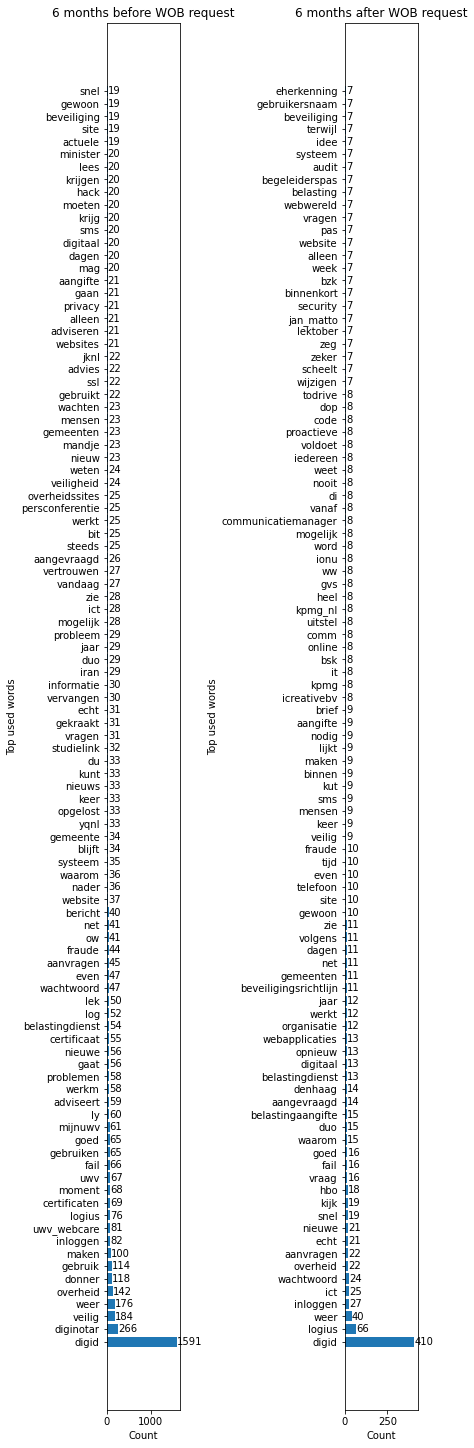

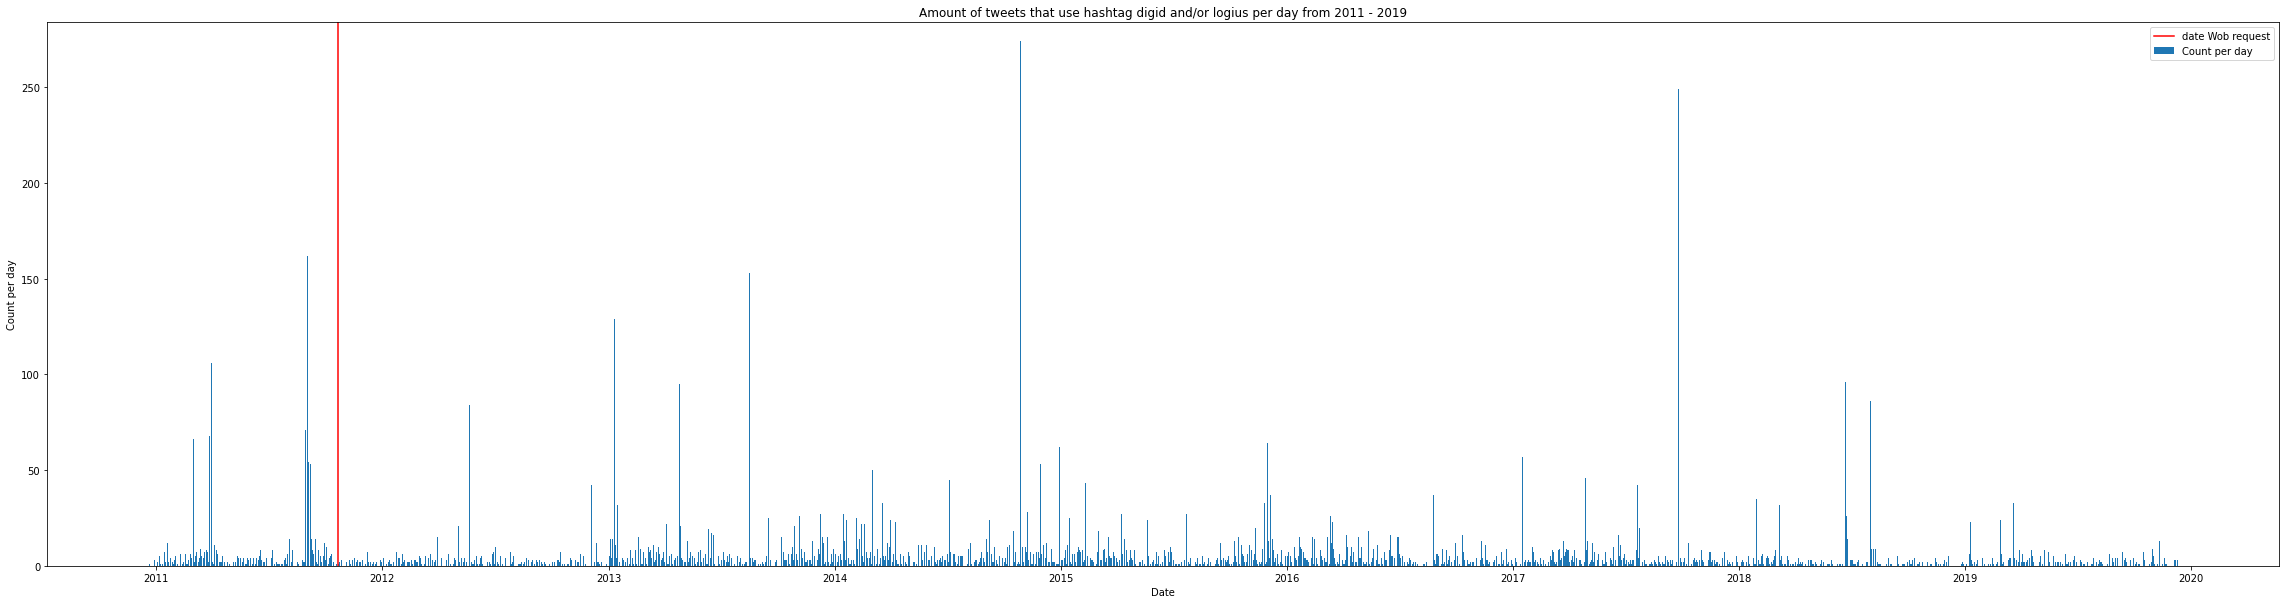

In [353]:
df_digid = get_dataframe("/Users/immelieve/Desktop/UNI/Bachelor/Bachelor jaar 4/Scriptie/Code/tweets_wob/imme_json/tag_digid.json")
df_logius = get_dataframe("/Users/immelieve/Desktop/UNI/Bachelor/Bachelor jaar 4/Scriptie/Code/tweets_wob/imme_json/tag_logius.json")
df_logius_digid = combine_two_dataframes(df_digid, df_logius, ['text','created_at'])
df_before, df_after, docs_before, docs_after, values_before, values_after = get_tweet_count_plots(df_logius_digid, '2011-10-21', 6, 100, stopwords, "digid and/or logius")


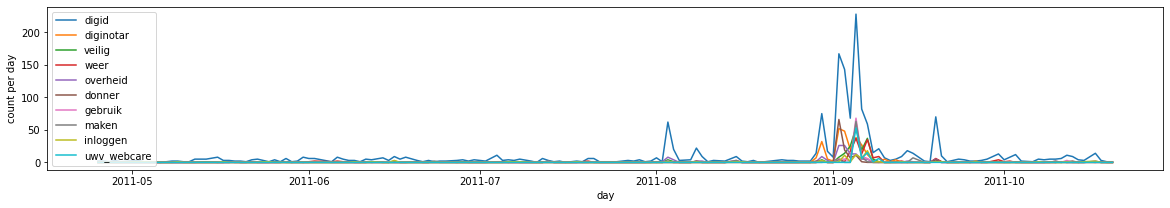

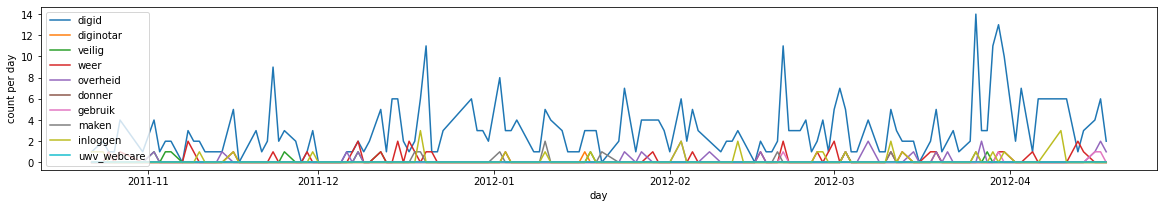

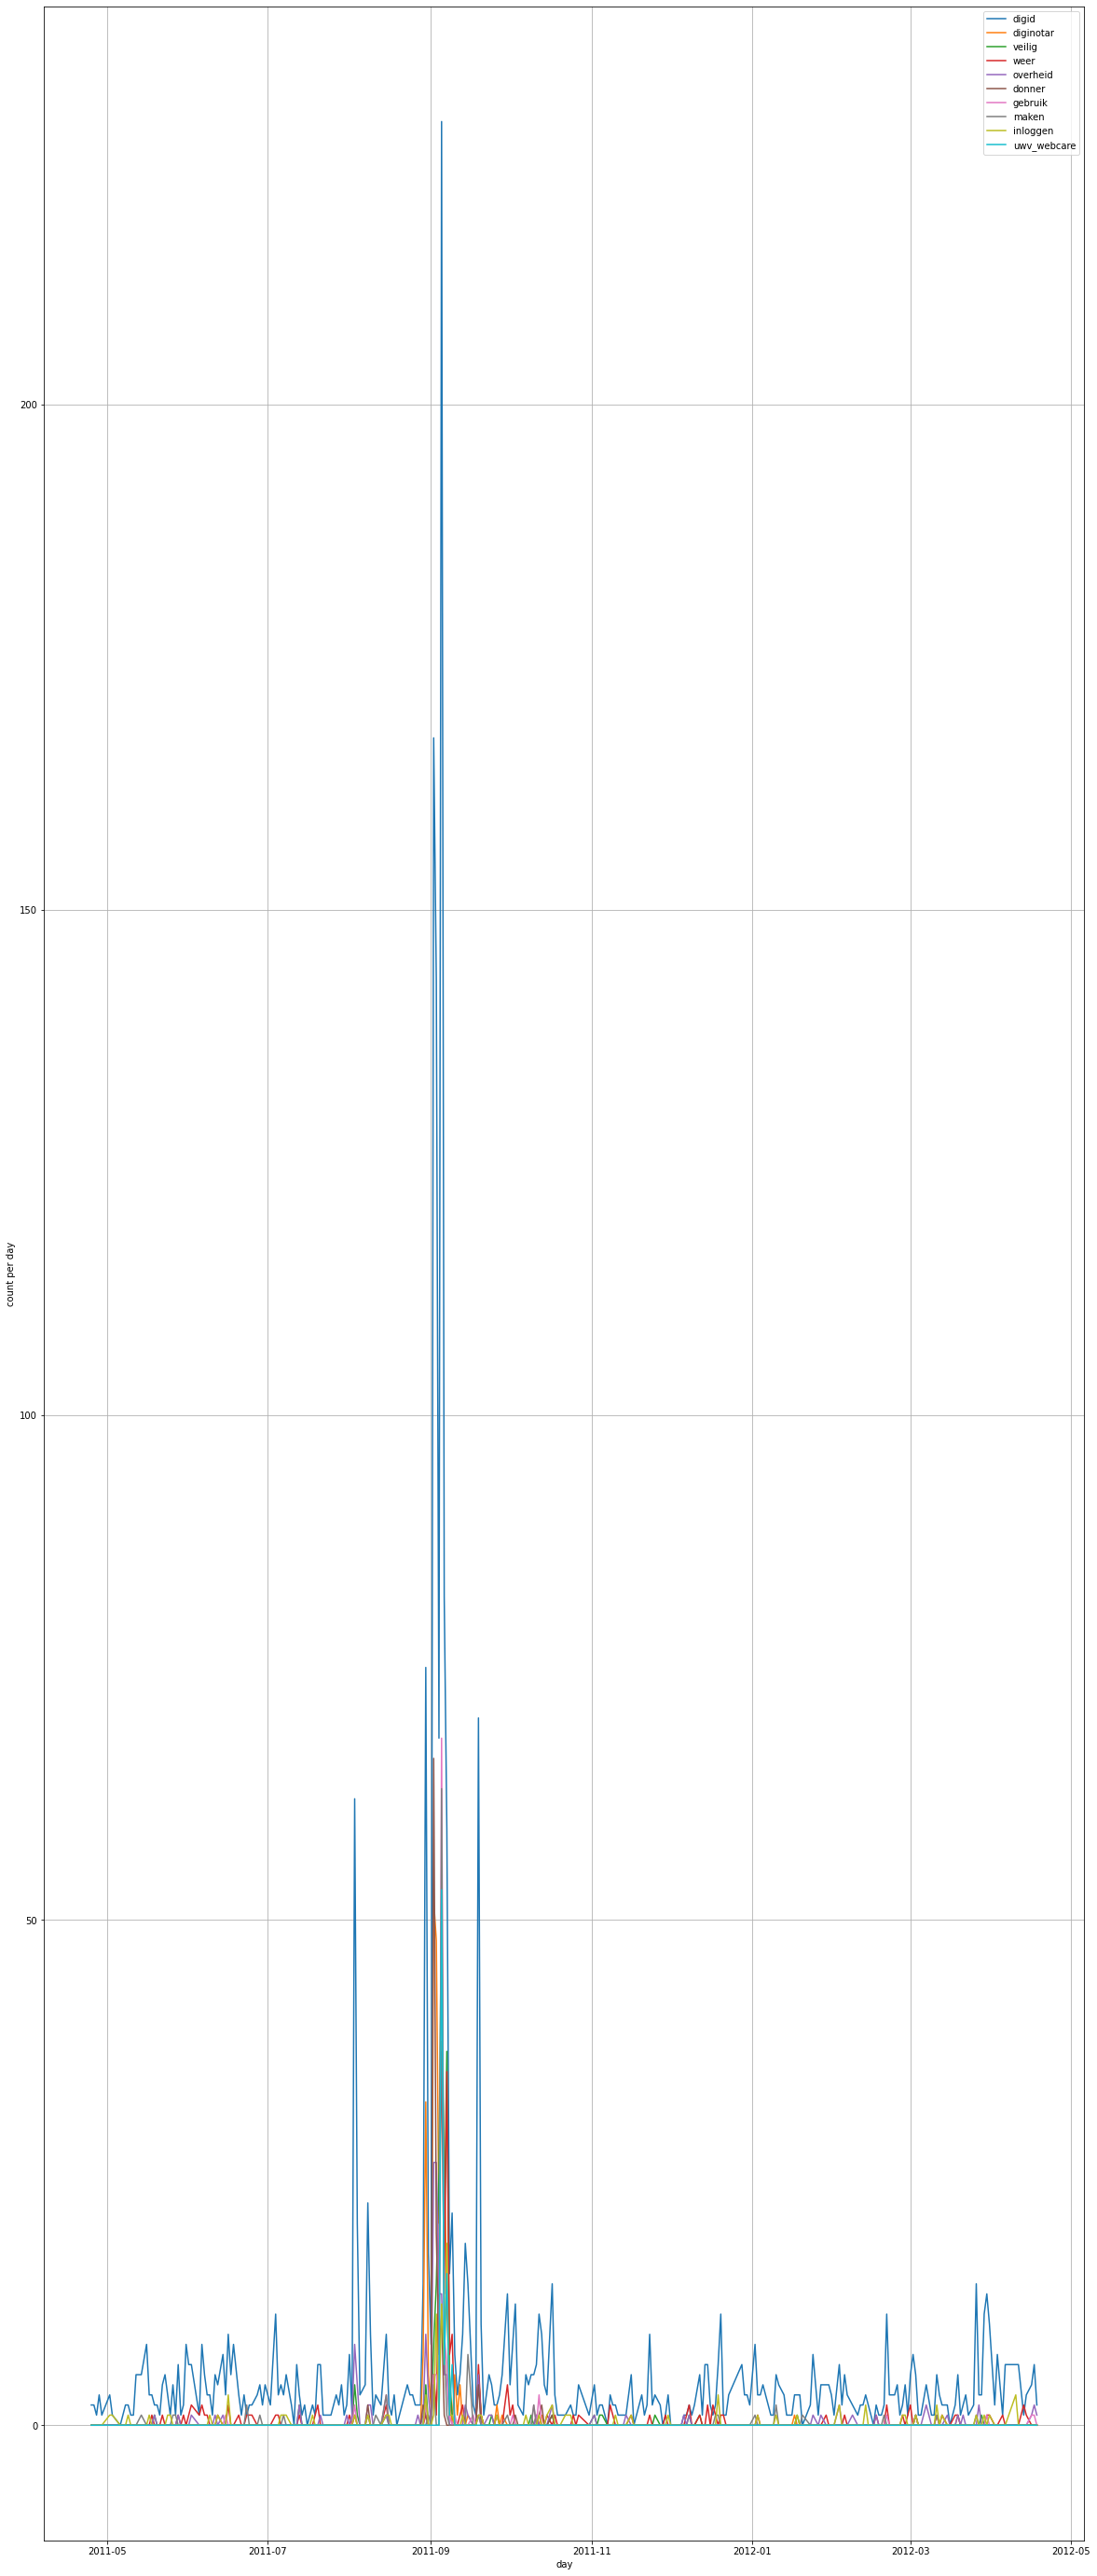

In [354]:
group_day_before, group_day_before, group_day_all = get_word_count_plot(df_before, df_after, docs_before, docs_after, values_before, 10, 0)

<ipython-input-260-985556f62f0b>:9: RuntimeWarning: invalid value encountered in true_divide
  return np.dot(v1,v2)/float(LA.norm(v1)*LA.norm(v2))
<ipython-input-260-985556f62f0b>:9: RuntimeWarning: invalid value encountered in true_divide
  return np.dot(v1,v2)/float(LA.norm(v1)*LA.norm(v2))


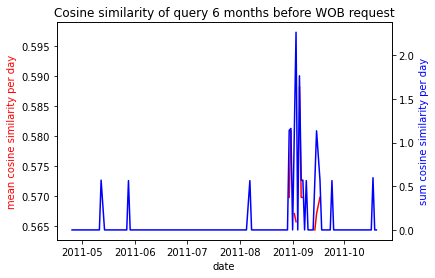

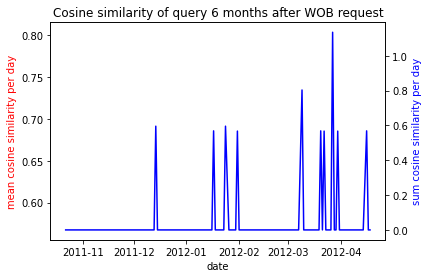

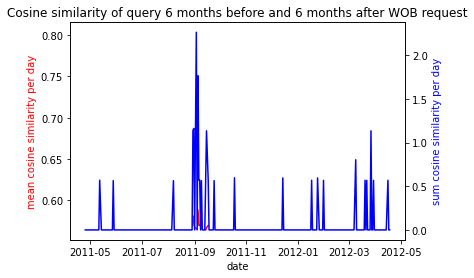

In [356]:
query = "het calamiteitenplan van Logius Digid Ov geweld personeel"
cosine_plot = plot_cosine_sim(query, df_before, df_after, docs_before, docs_after)

<Figure size 432x288 with 0 Axes>

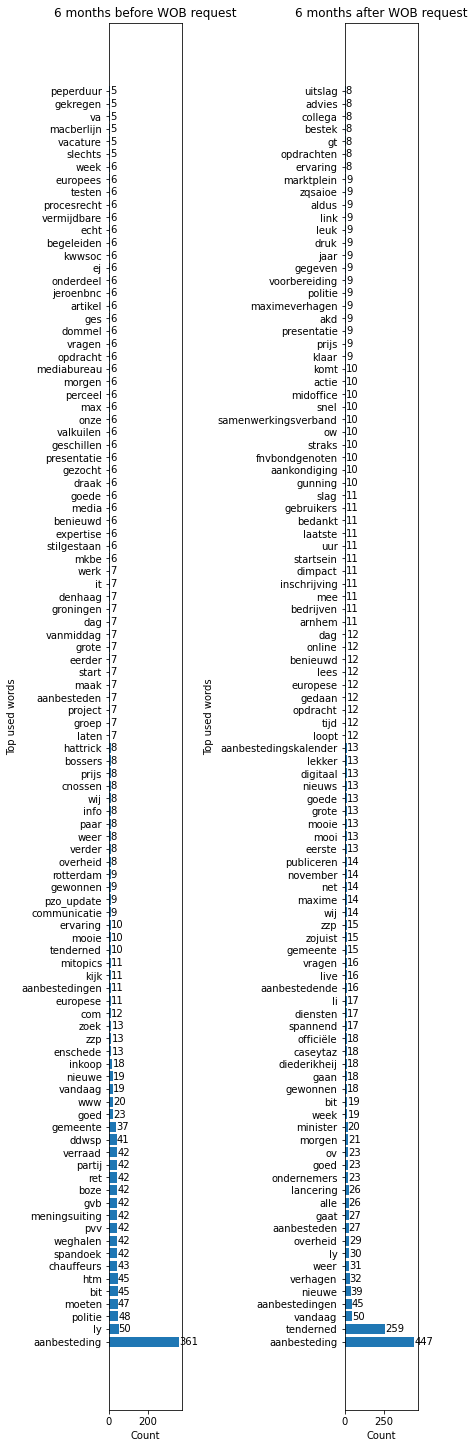

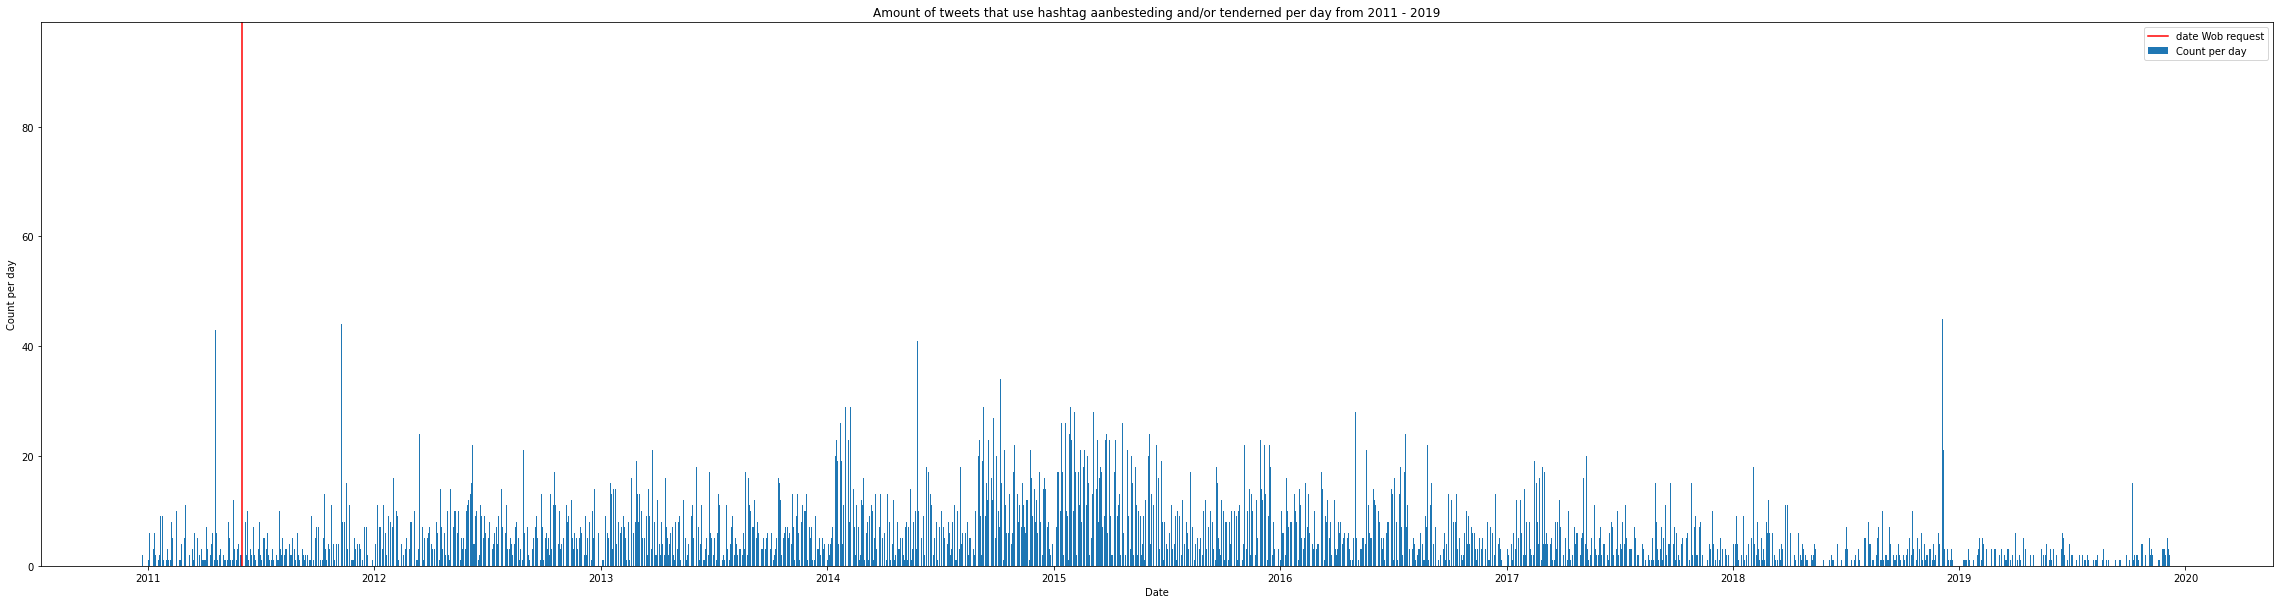

<ipython-input-260-985556f62f0b>:9: RuntimeWarning: invalid value encountered in true_divide
  return np.dot(v1,v2)/float(LA.norm(v1)*LA.norm(v2))


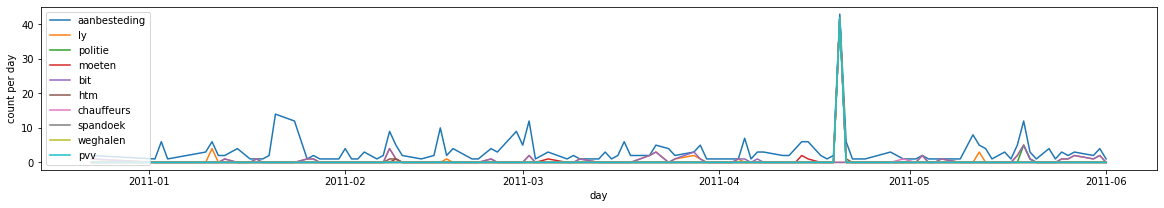

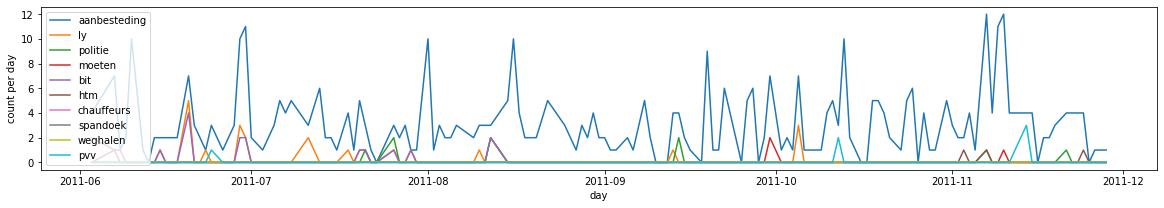

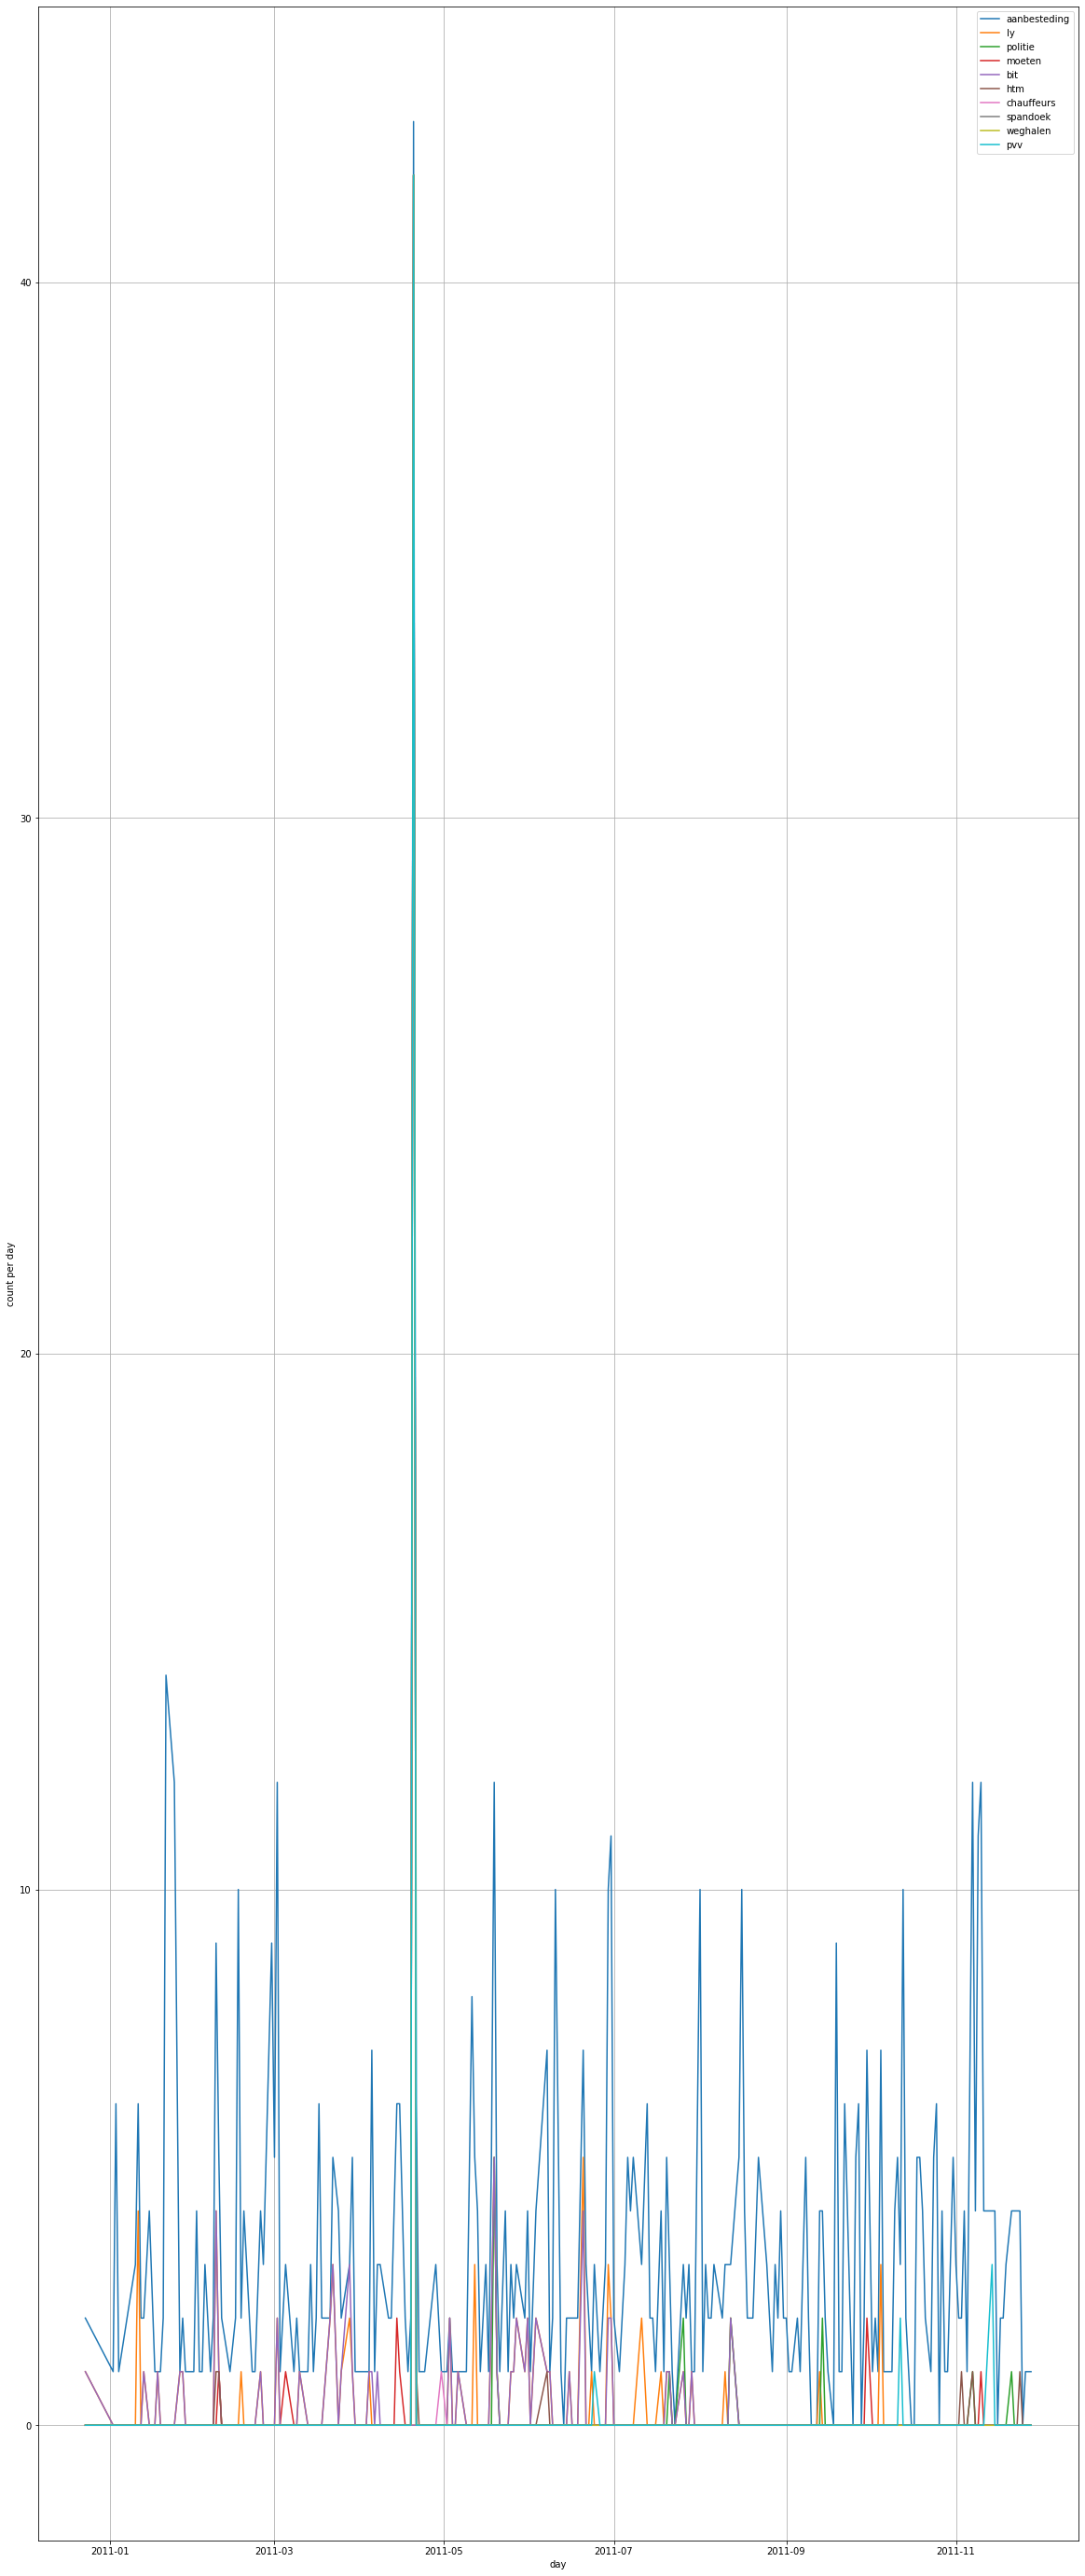

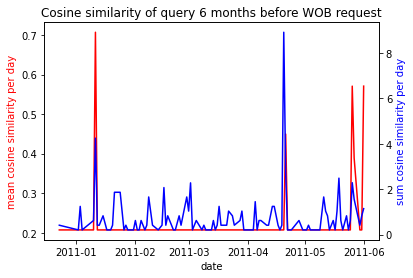

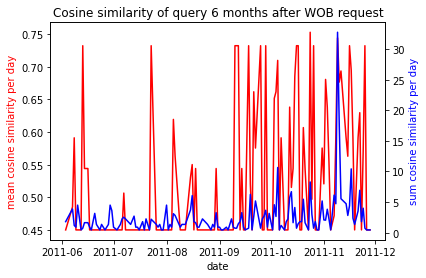

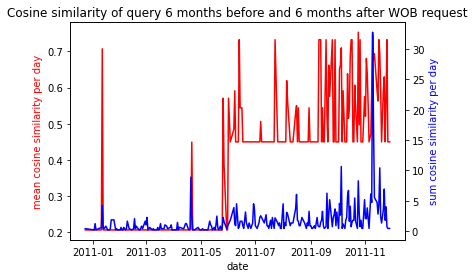

In [283]:
df_aanbesteding = pd.read_json("/Users/immelieve/Desktop/UNI/Bachelor/Bachelor jaar 4/Scriptie/Code/tweets_wob/imme_json/tag_aanbesteding.json", lines=True)
df_tenderned = pd.read_json("/Users/immelieve/Desktop/UNI/Bachelor/Bachelor jaar 4/Scriptie/Code/tweets_wob/imme_json/tag_tenderned.json", lines=True)
dt_aanbesteding_tenderned = combine_two_dataframes(df_aanbesteding, df_tenderned, ['text','created_at'])
df_before, df_after, docs_before, docs_after, values_before, values_after = get_tweet_count_plots(dt_aanbesteding_tenderned, '2011-06-01', 6, 100, stopwords, "aanbesteding and/or tenderned")
group_day_before, group_day_before, group_day_all = get_word_count_plot(df_before, df_after, docs_before, docs_after, values_before, 10, 0)
query = "Raamovereenkomst aanbesteding communicatiediensten TenderNed"
cosine_plot = plot_cosine_sim(query, df_before, df_after, docs_before, docs_after)

<Figure size 432x288 with 0 Axes>

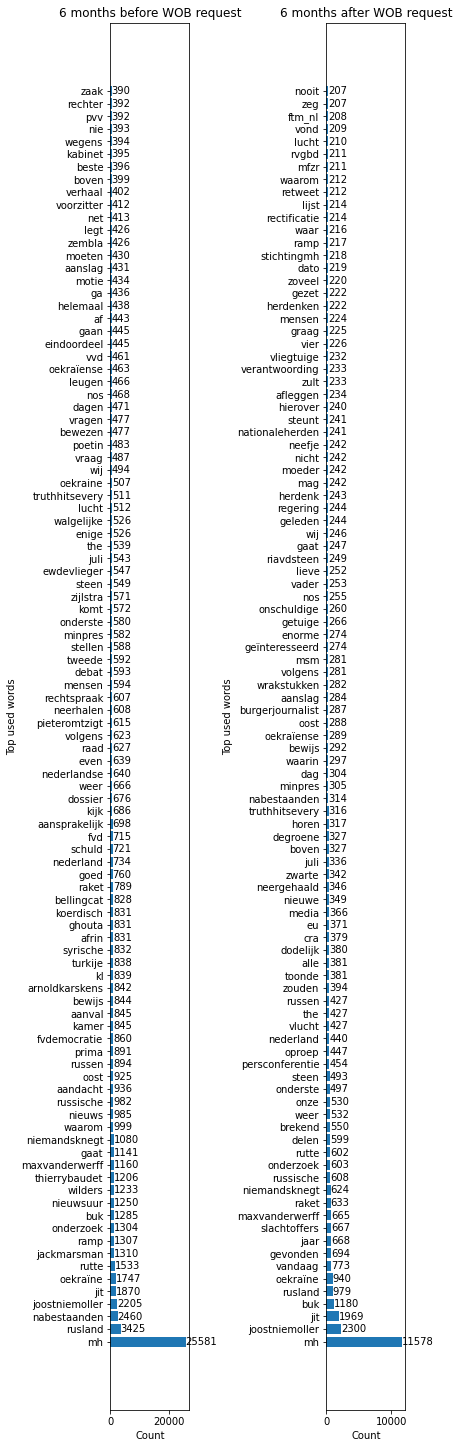

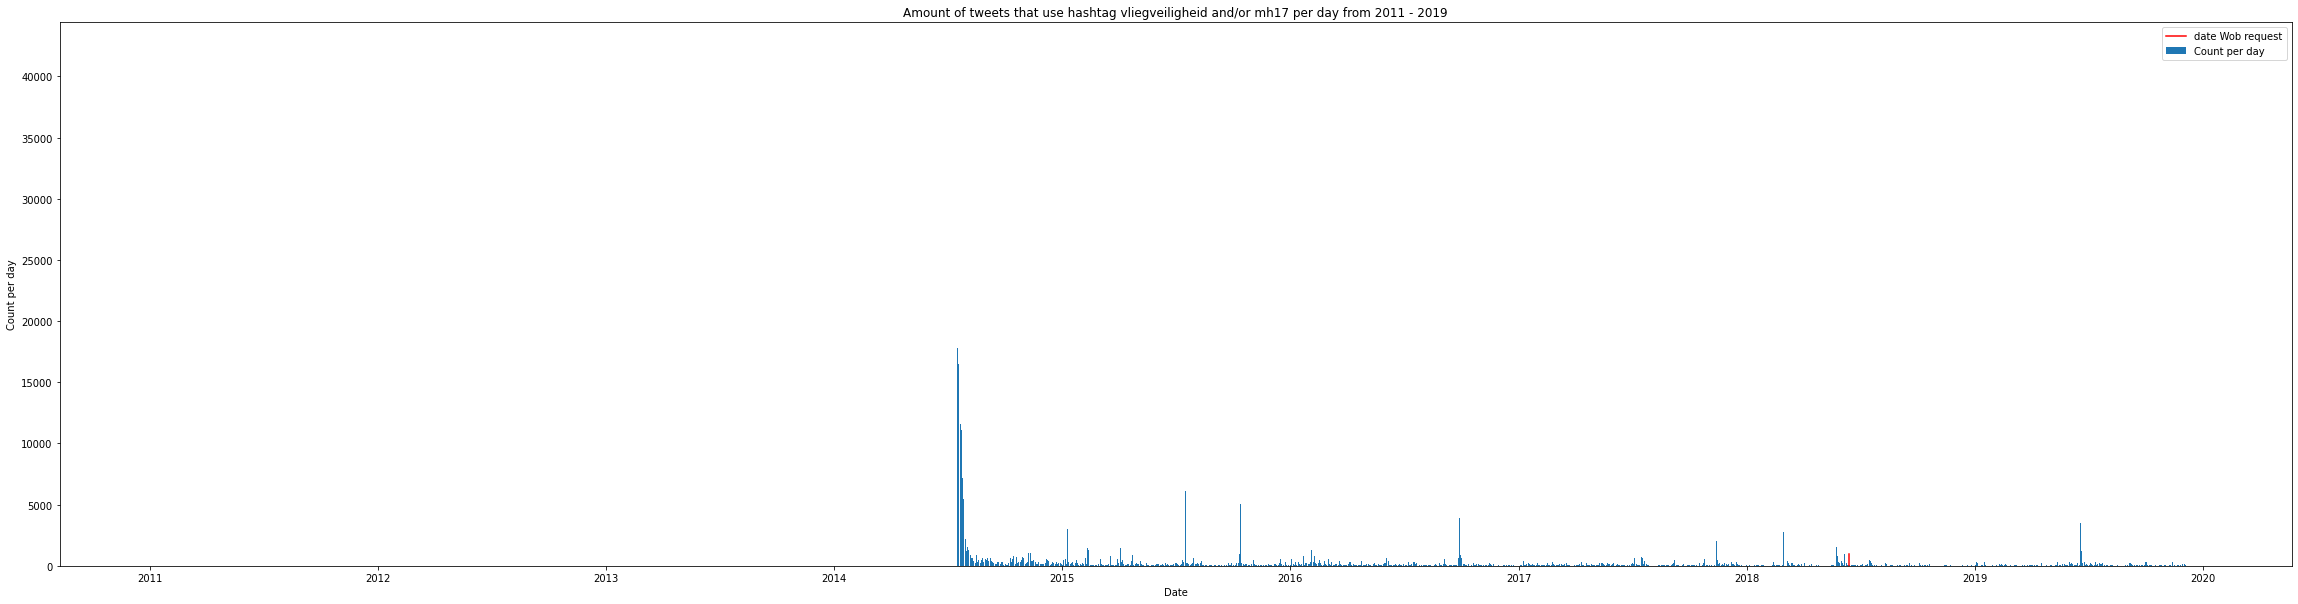

<ipython-input-260-985556f62f0b>:9: RuntimeWarning: invalid value encountered in true_divide
  return np.dot(v1,v2)/float(LA.norm(v1)*LA.norm(v2))
<ipython-input-260-985556f62f0b>:9: RuntimeWarning: invalid value encountered in true_divide
  return np.dot(v1,v2)/float(LA.norm(v1)*LA.norm(v2))


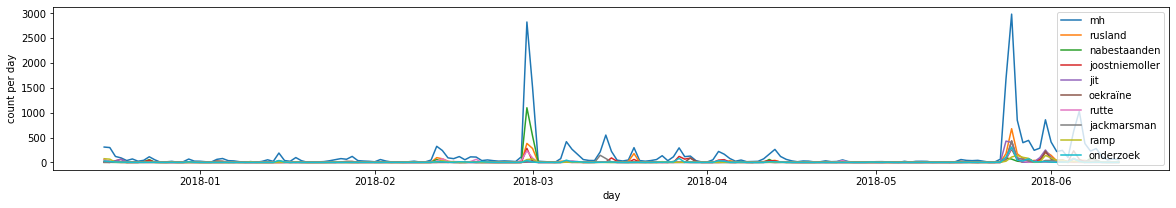

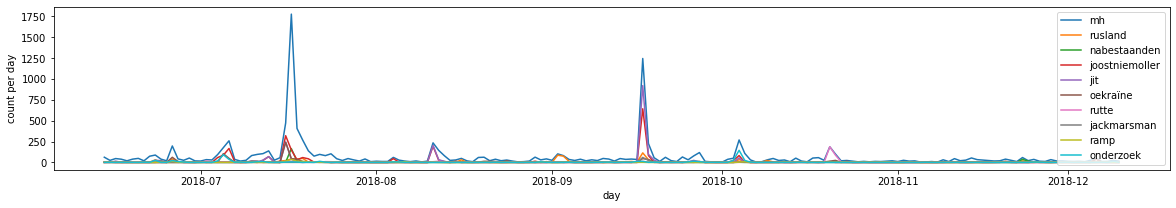

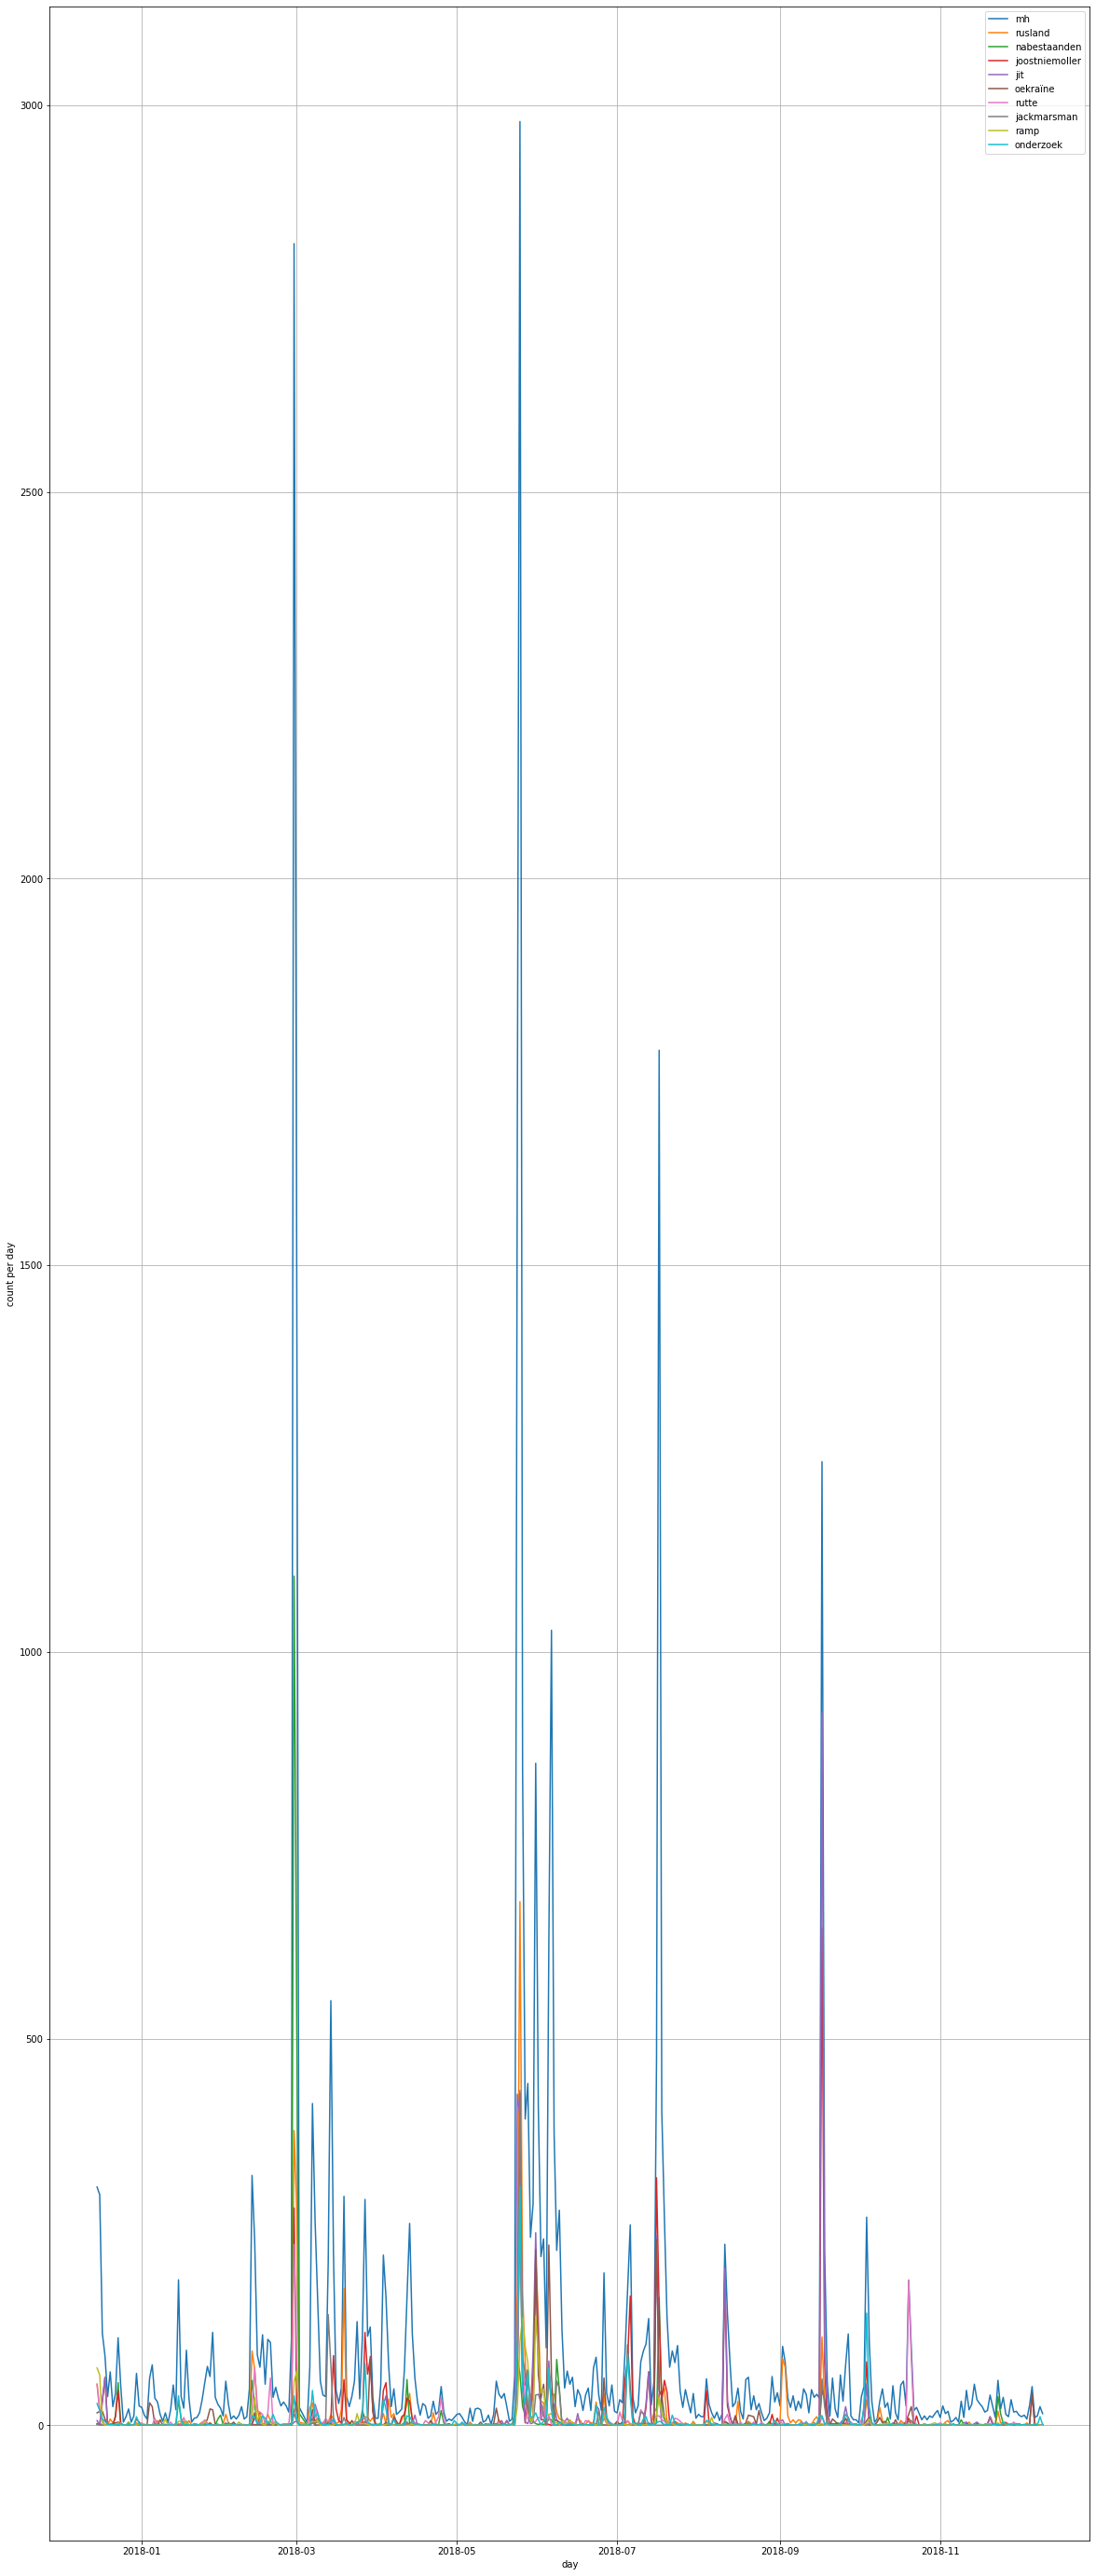

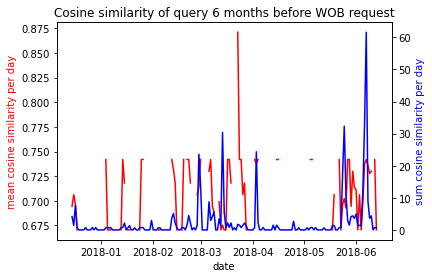

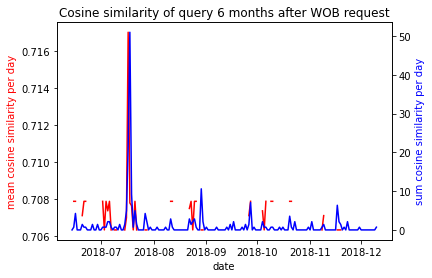

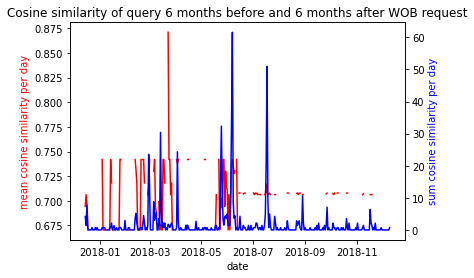

In [293]:
df_vliegveiligheid = pd.read_json("/Users/immelieve/Desktop/UNI/Bachelor/Bachelor jaar 4/Scriptie/Code/tweets_wob/imme_json/tag_vliegveiligheid.json", lines=True)
df_mh17 = pd.read_json("/Users/immelieve/Desktop/UNI/Bachelor/Bachelor jaar 4/Scriptie/Code/tweets_wob/imme_json/tag_mh17.json", lines=True)
df_vliegveiligheid_mh17 = combine_two_dataframes(df_vliegveiligheid, df_mh17, ['text','created_at'])
df_before, df_after, docs_before, docs_after, values_before, values_after = get_tweet_count_plots(df_vliegveiligheid_mh17,'2018-06-13', 6, 100, stopwords, "vliegveiligheid and/or mh17")
group_day_before, group_day_before, group_day_all = get_word_count_plot(df_before, df_after, docs_before, docs_after, values_before, 10, 0)
query = "Convenant deling van dreigingsinformatie voor de Burgerluchtvaart"
cosine_plot = plot_cosine_sim(query, df_before, df_after, docs_before, docs_after)

<Figure size 432x288 with 0 Axes>

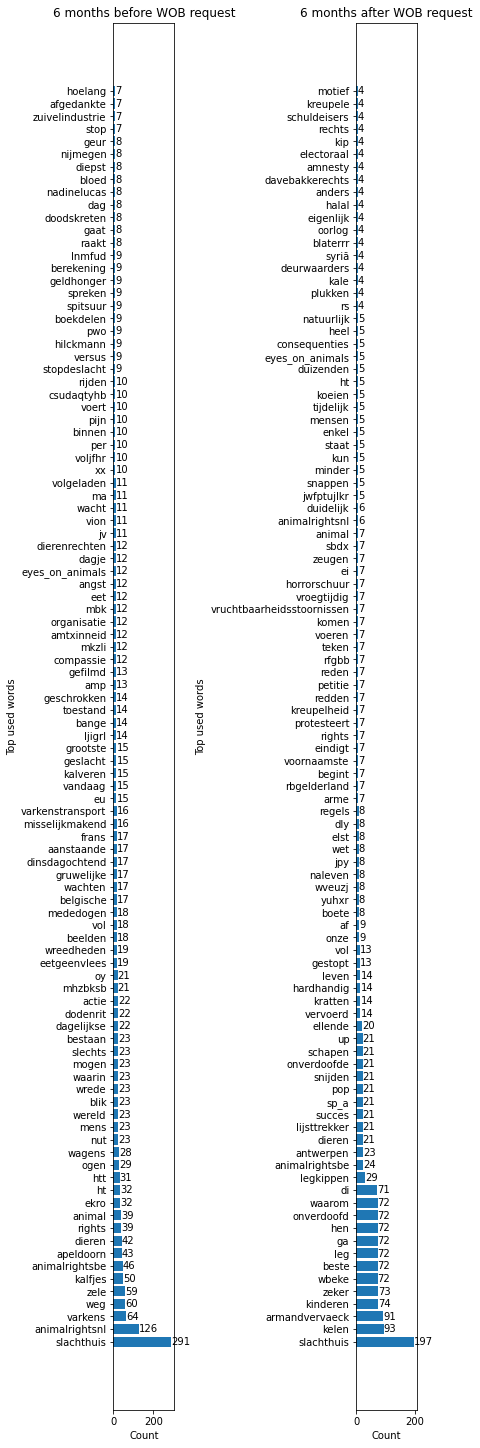

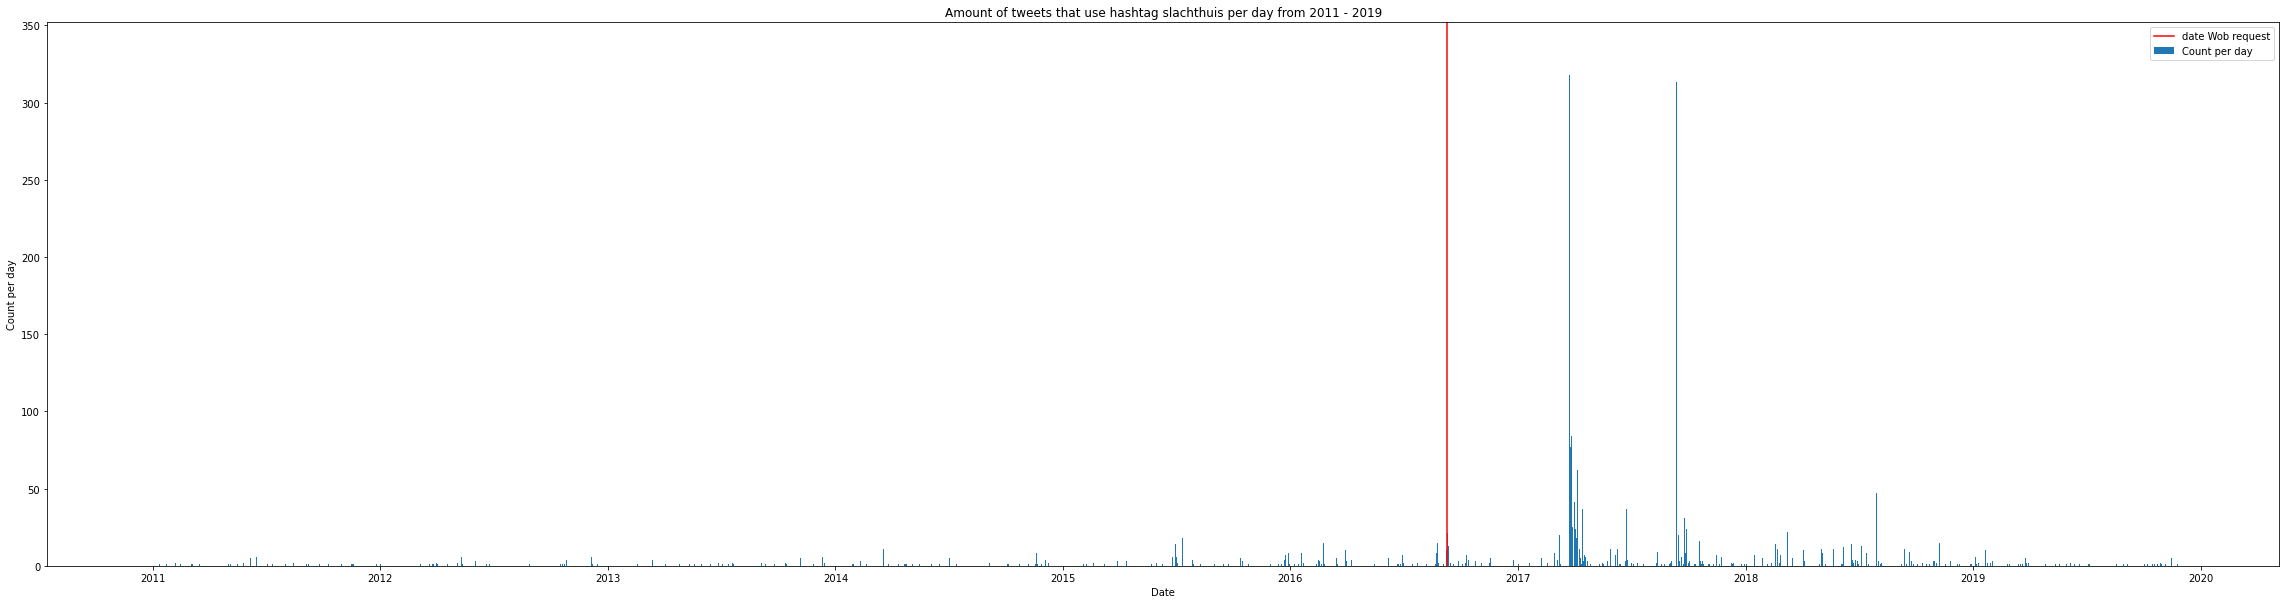

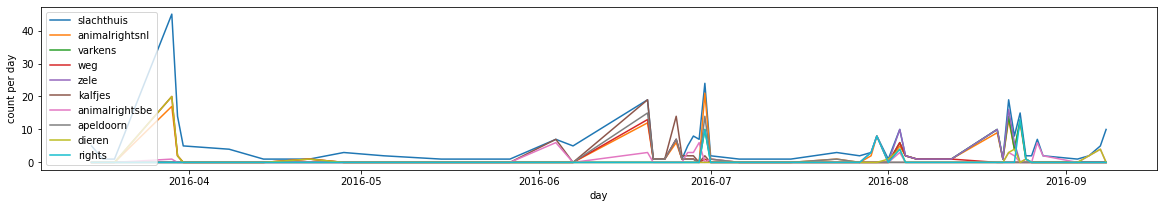

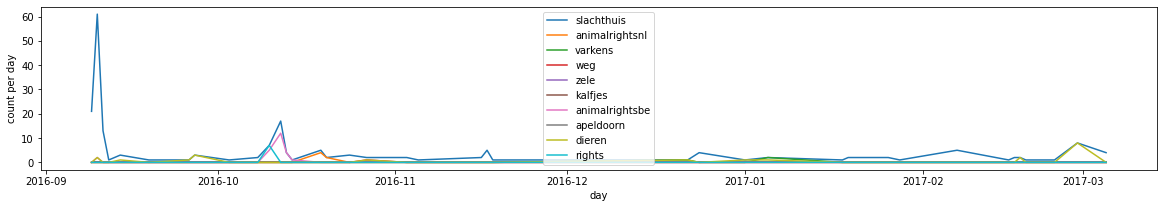

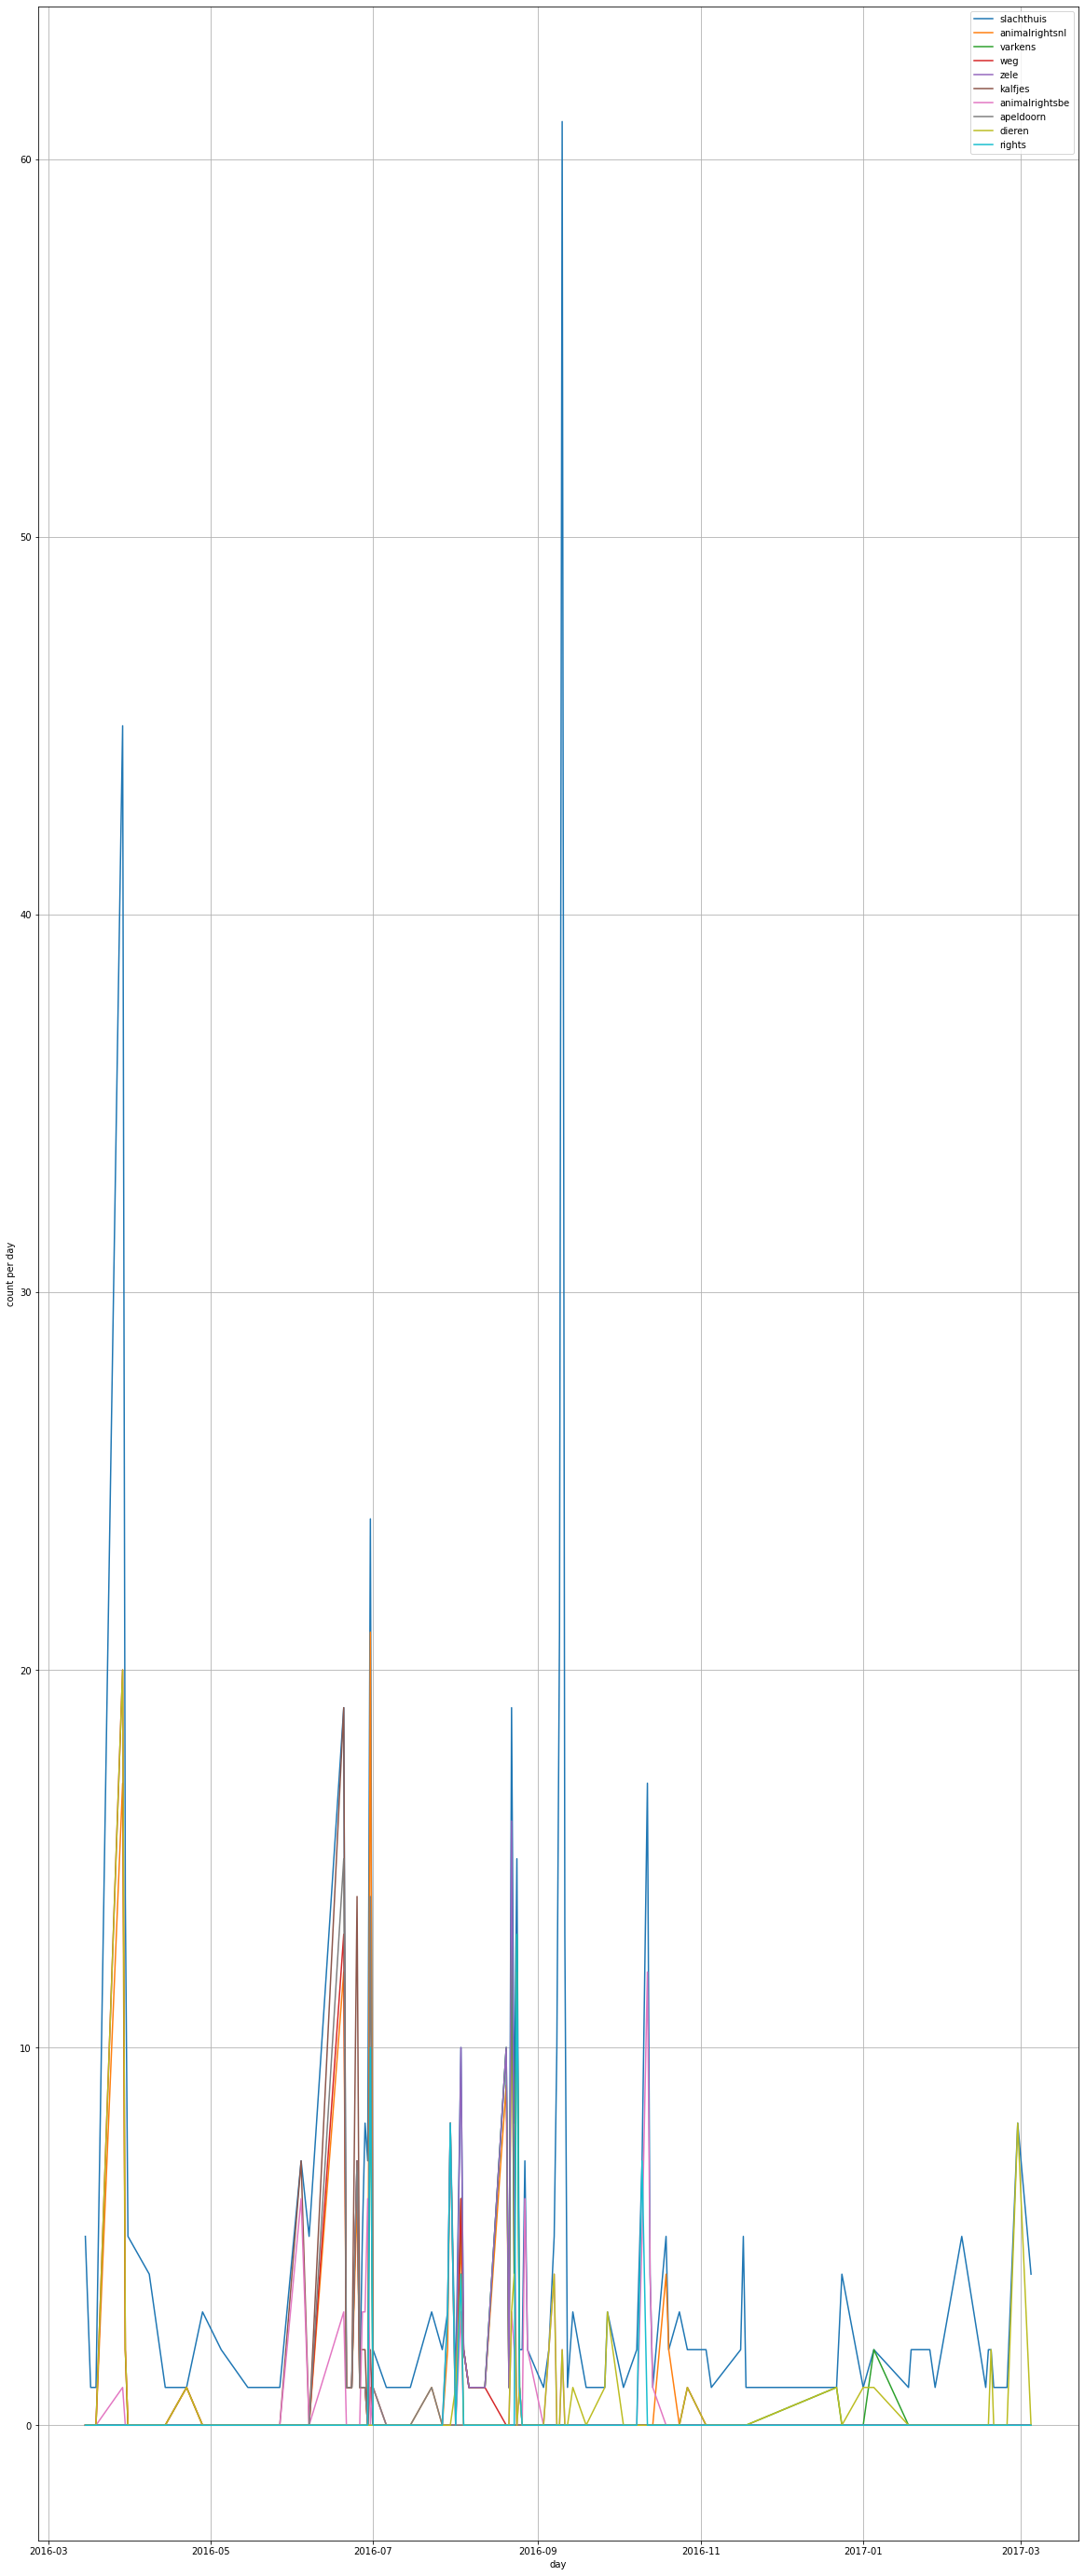

In [351]:
df_slachthuis = pd.read_json("/Users/immelieve/Desktop/UNI/Bachelor/Bachelor jaar 4/Scriptie/Code/tweets_wob/imme_json/tag_slachthuis.json", lines=True)
df_before, df_after, docs_before, docs_after, values_before, values_after = get_tweet_count_plots(df_slachthuis,'2016-09-08', 6, 100, stopwords, "slachthuis")
group_day_before, group_day_before, group_day_all = get_word_count_plot(df_before, df_after, docs_before, docs_after, values_before, 10, 0)


<Figure size 432x288 with 0 Axes>

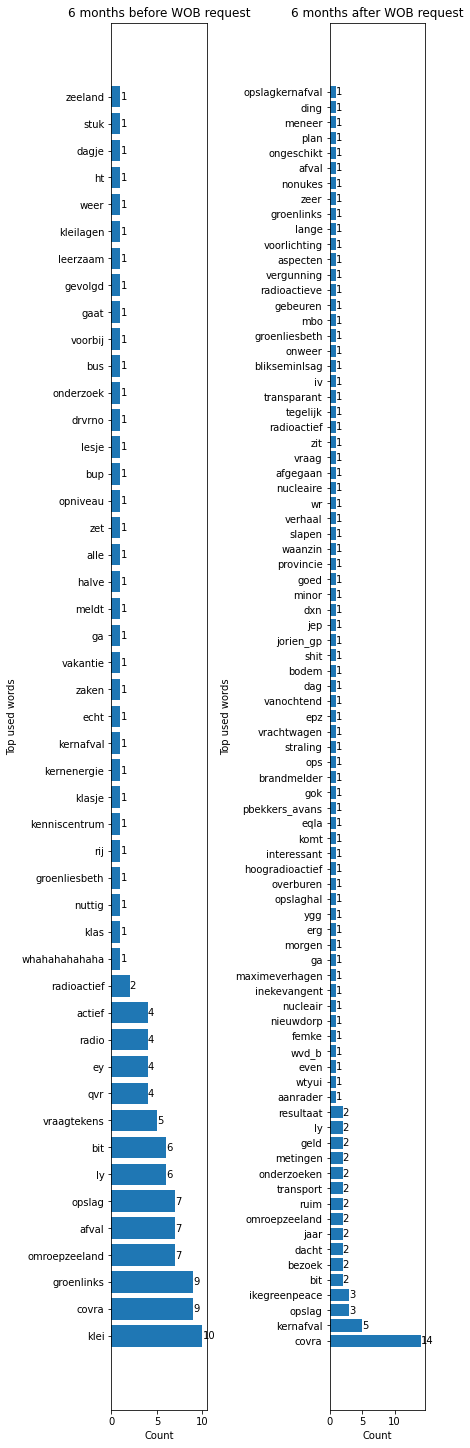

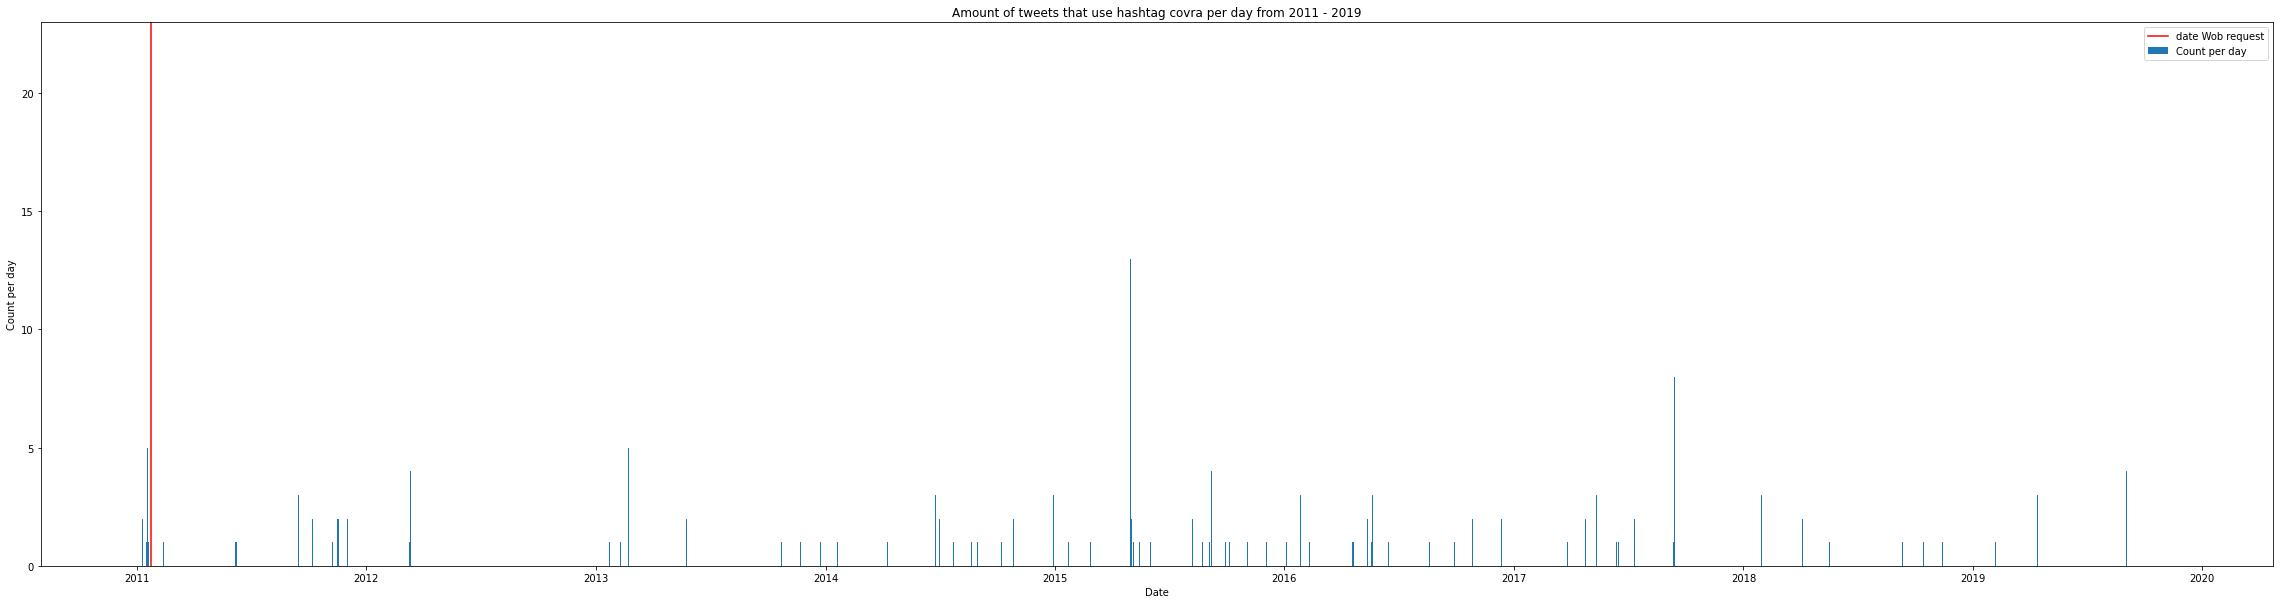

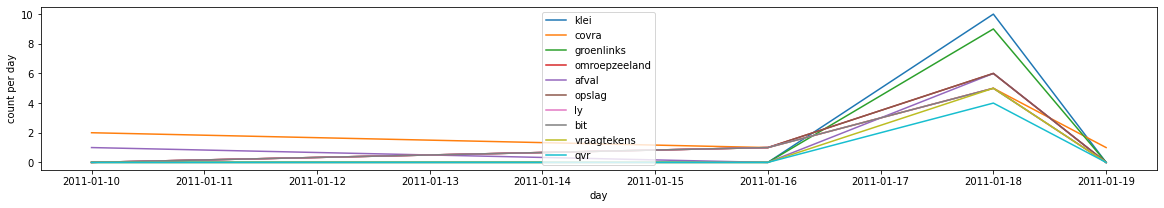

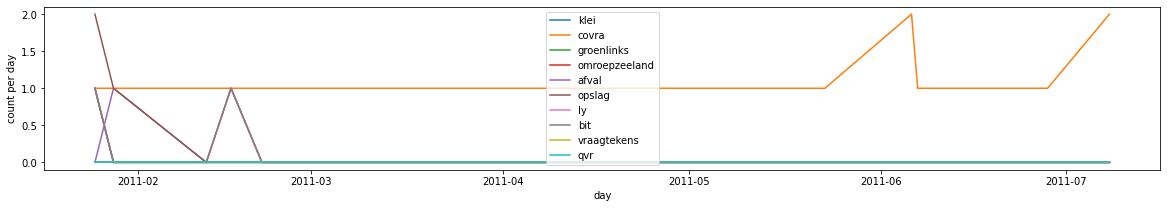

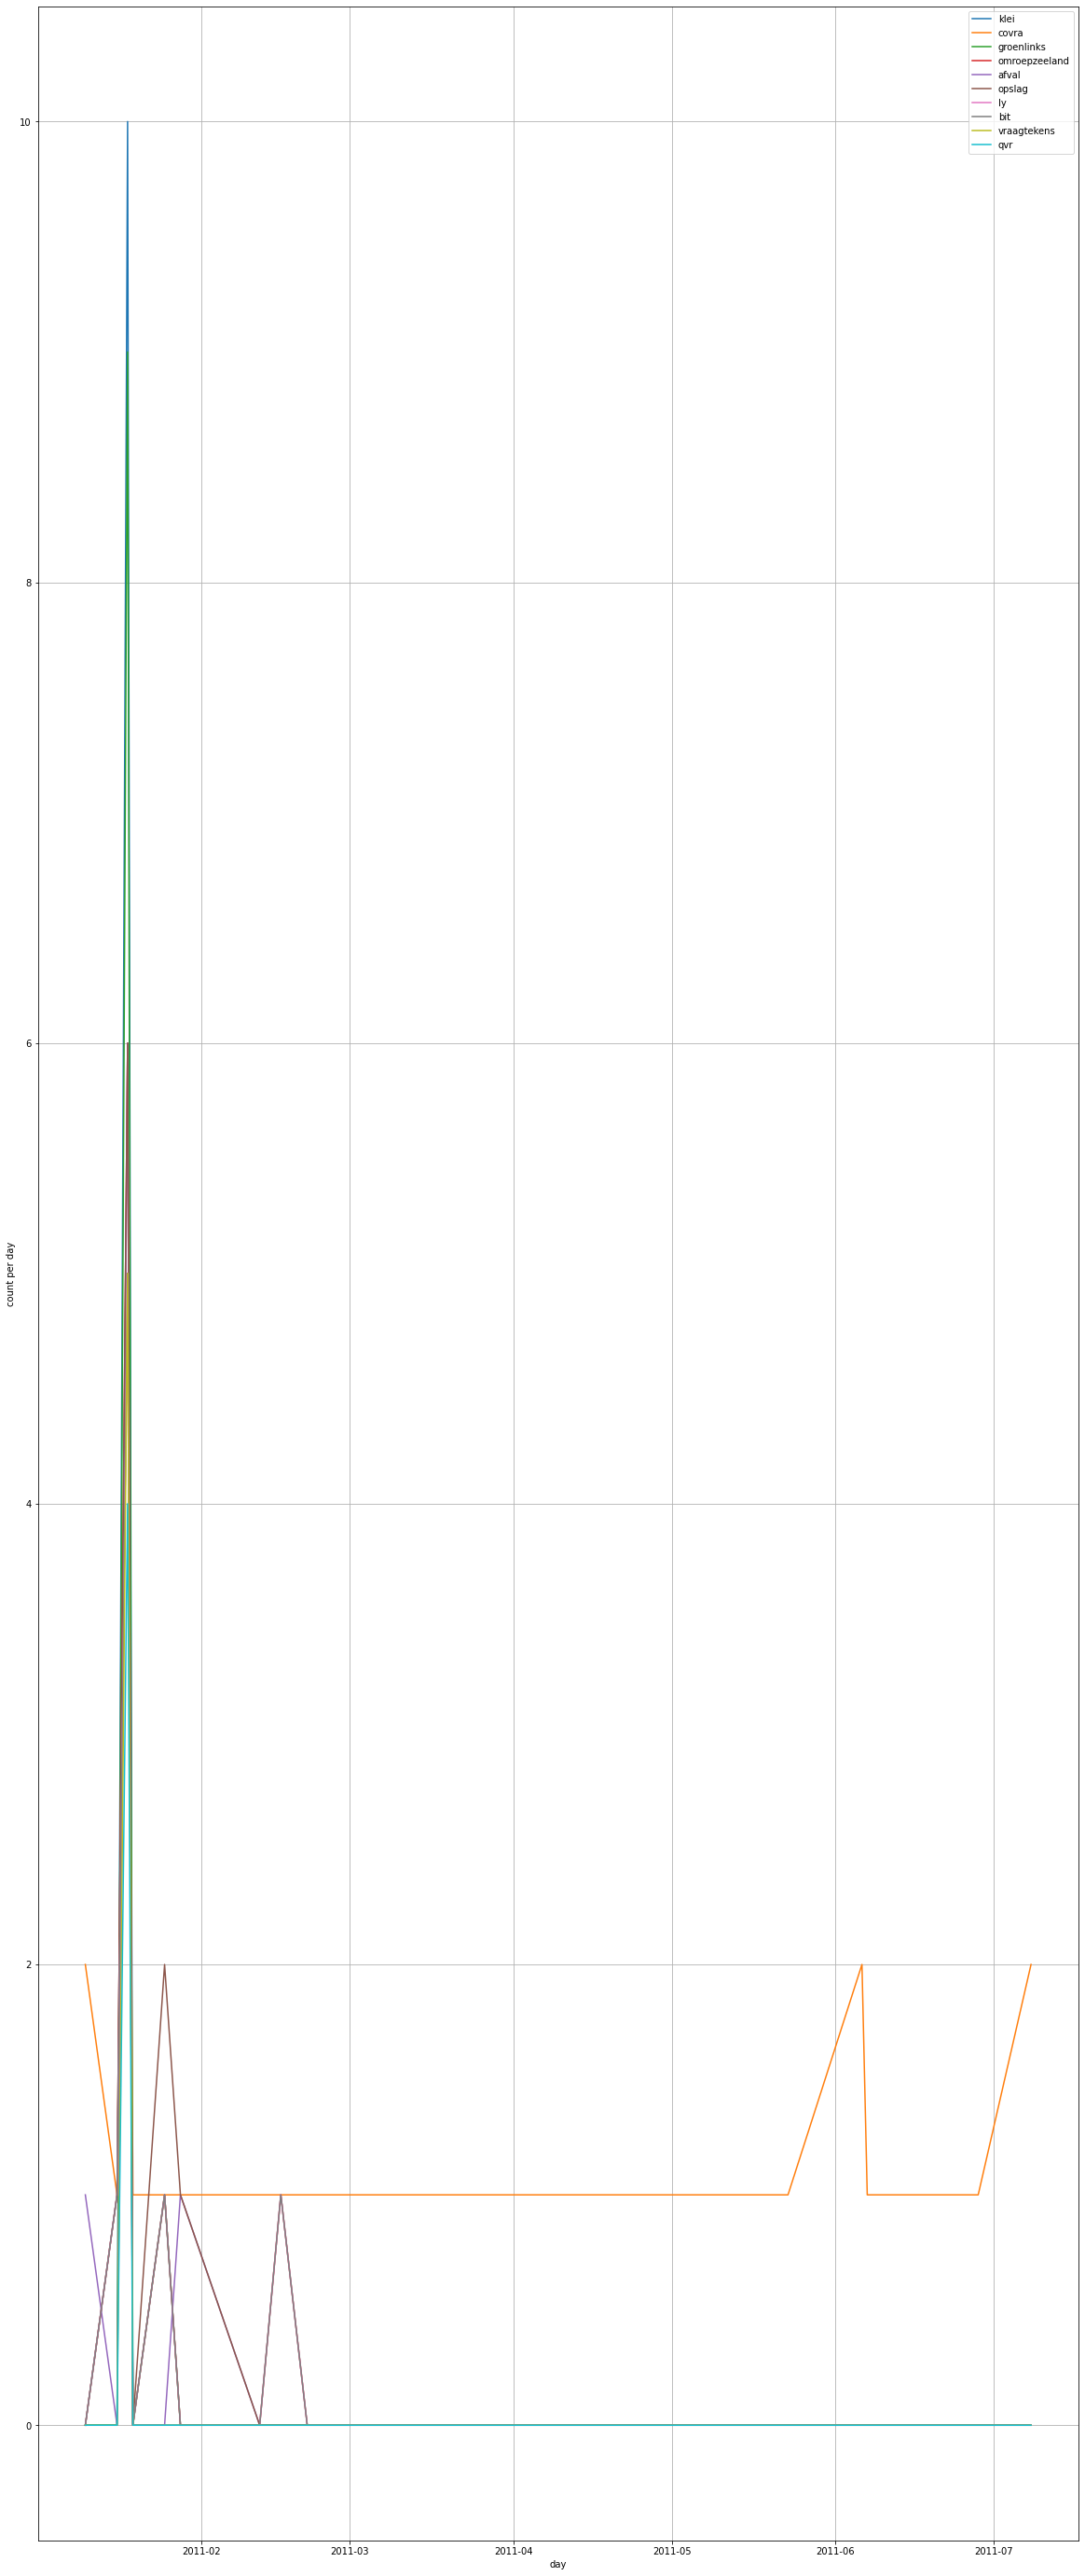

In [352]:
df_covra = pd.read_json("/Users/immelieve/Desktop/UNI/Bachelor/Bachelor jaar 4/Scriptie/Code/tweets_wob/imme_json/tag_covra.json", lines=True)
df_before, df_after, docs_before, docs_after, values_before, values_after = get_tweet_count_plots(df_covra,'2011-01-24', 6, 100, stopwords, "covra")
group_day_before, group_day_before, group_day_all = get_word_count_plot(df_before, df_after, docs_before, docs_after, values_before, 10, 0)

<Figure size 432x288 with 0 Axes>

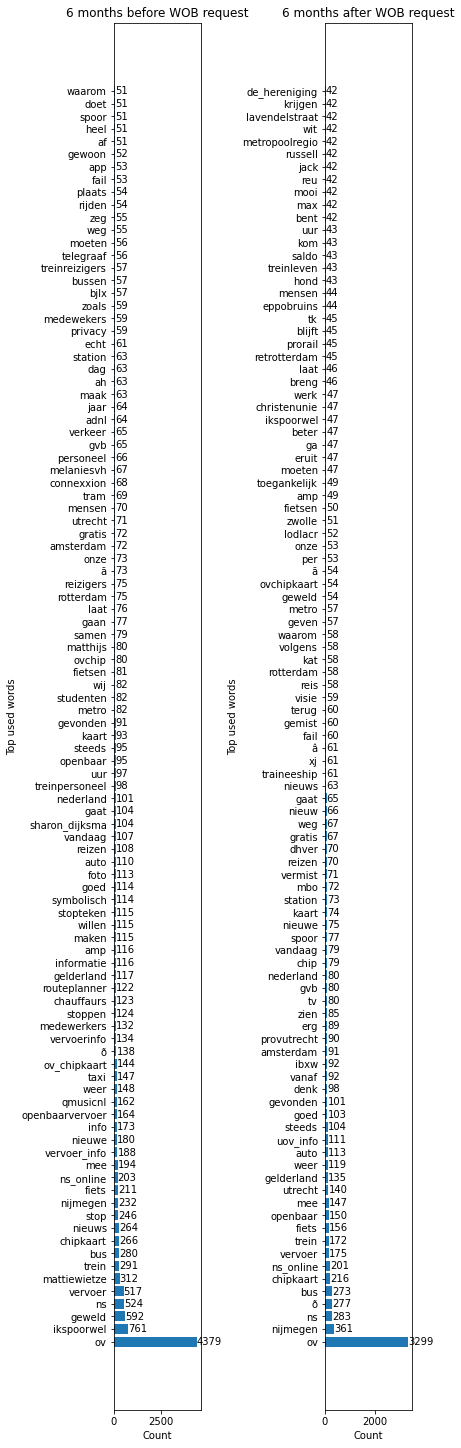

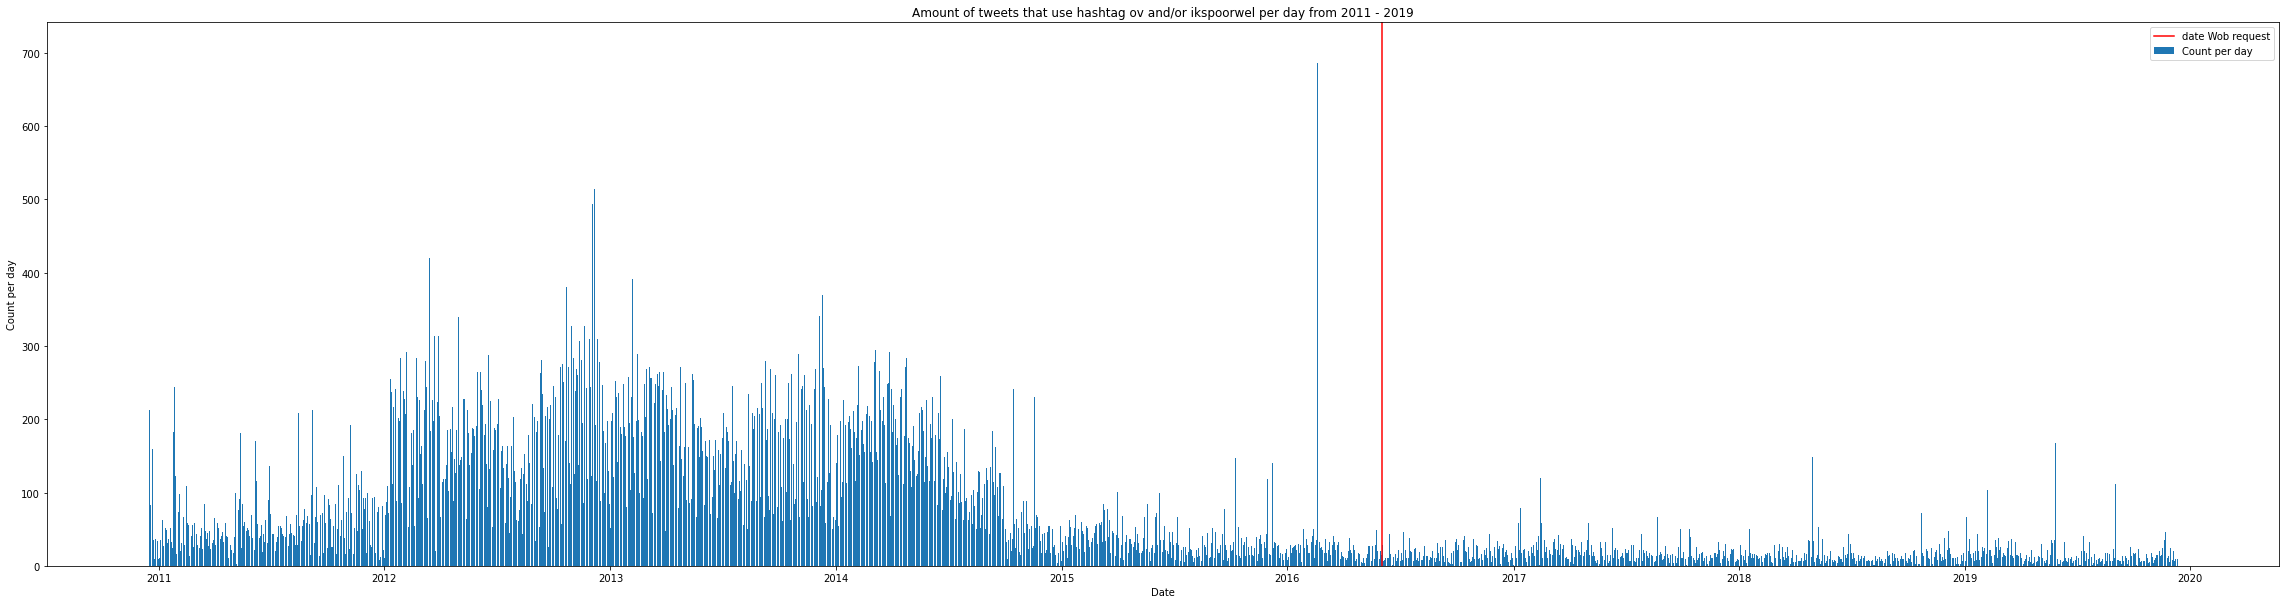

<ipython-input-260-985556f62f0b>:9: RuntimeWarning: invalid value encountered in true_divide
  return np.dot(v1,v2)/float(LA.norm(v1)*LA.norm(v2))
<ipython-input-260-985556f62f0b>:9: RuntimeWarning: invalid value encountered in true_divide
  return np.dot(v1,v2)/float(LA.norm(v1)*LA.norm(v2))


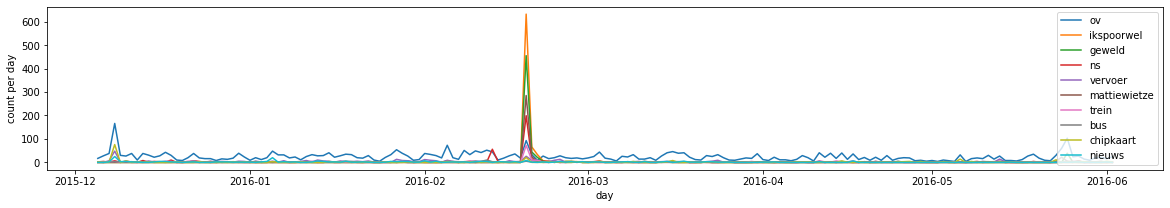

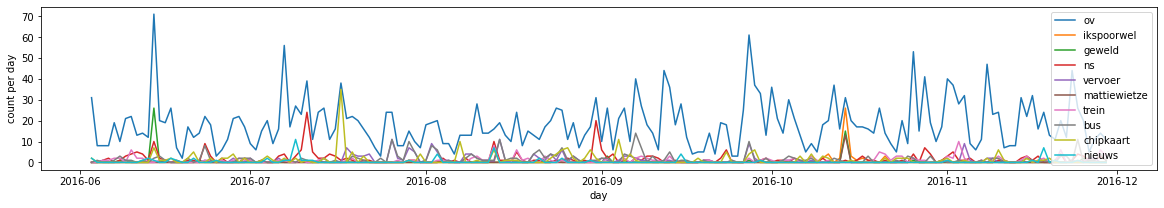

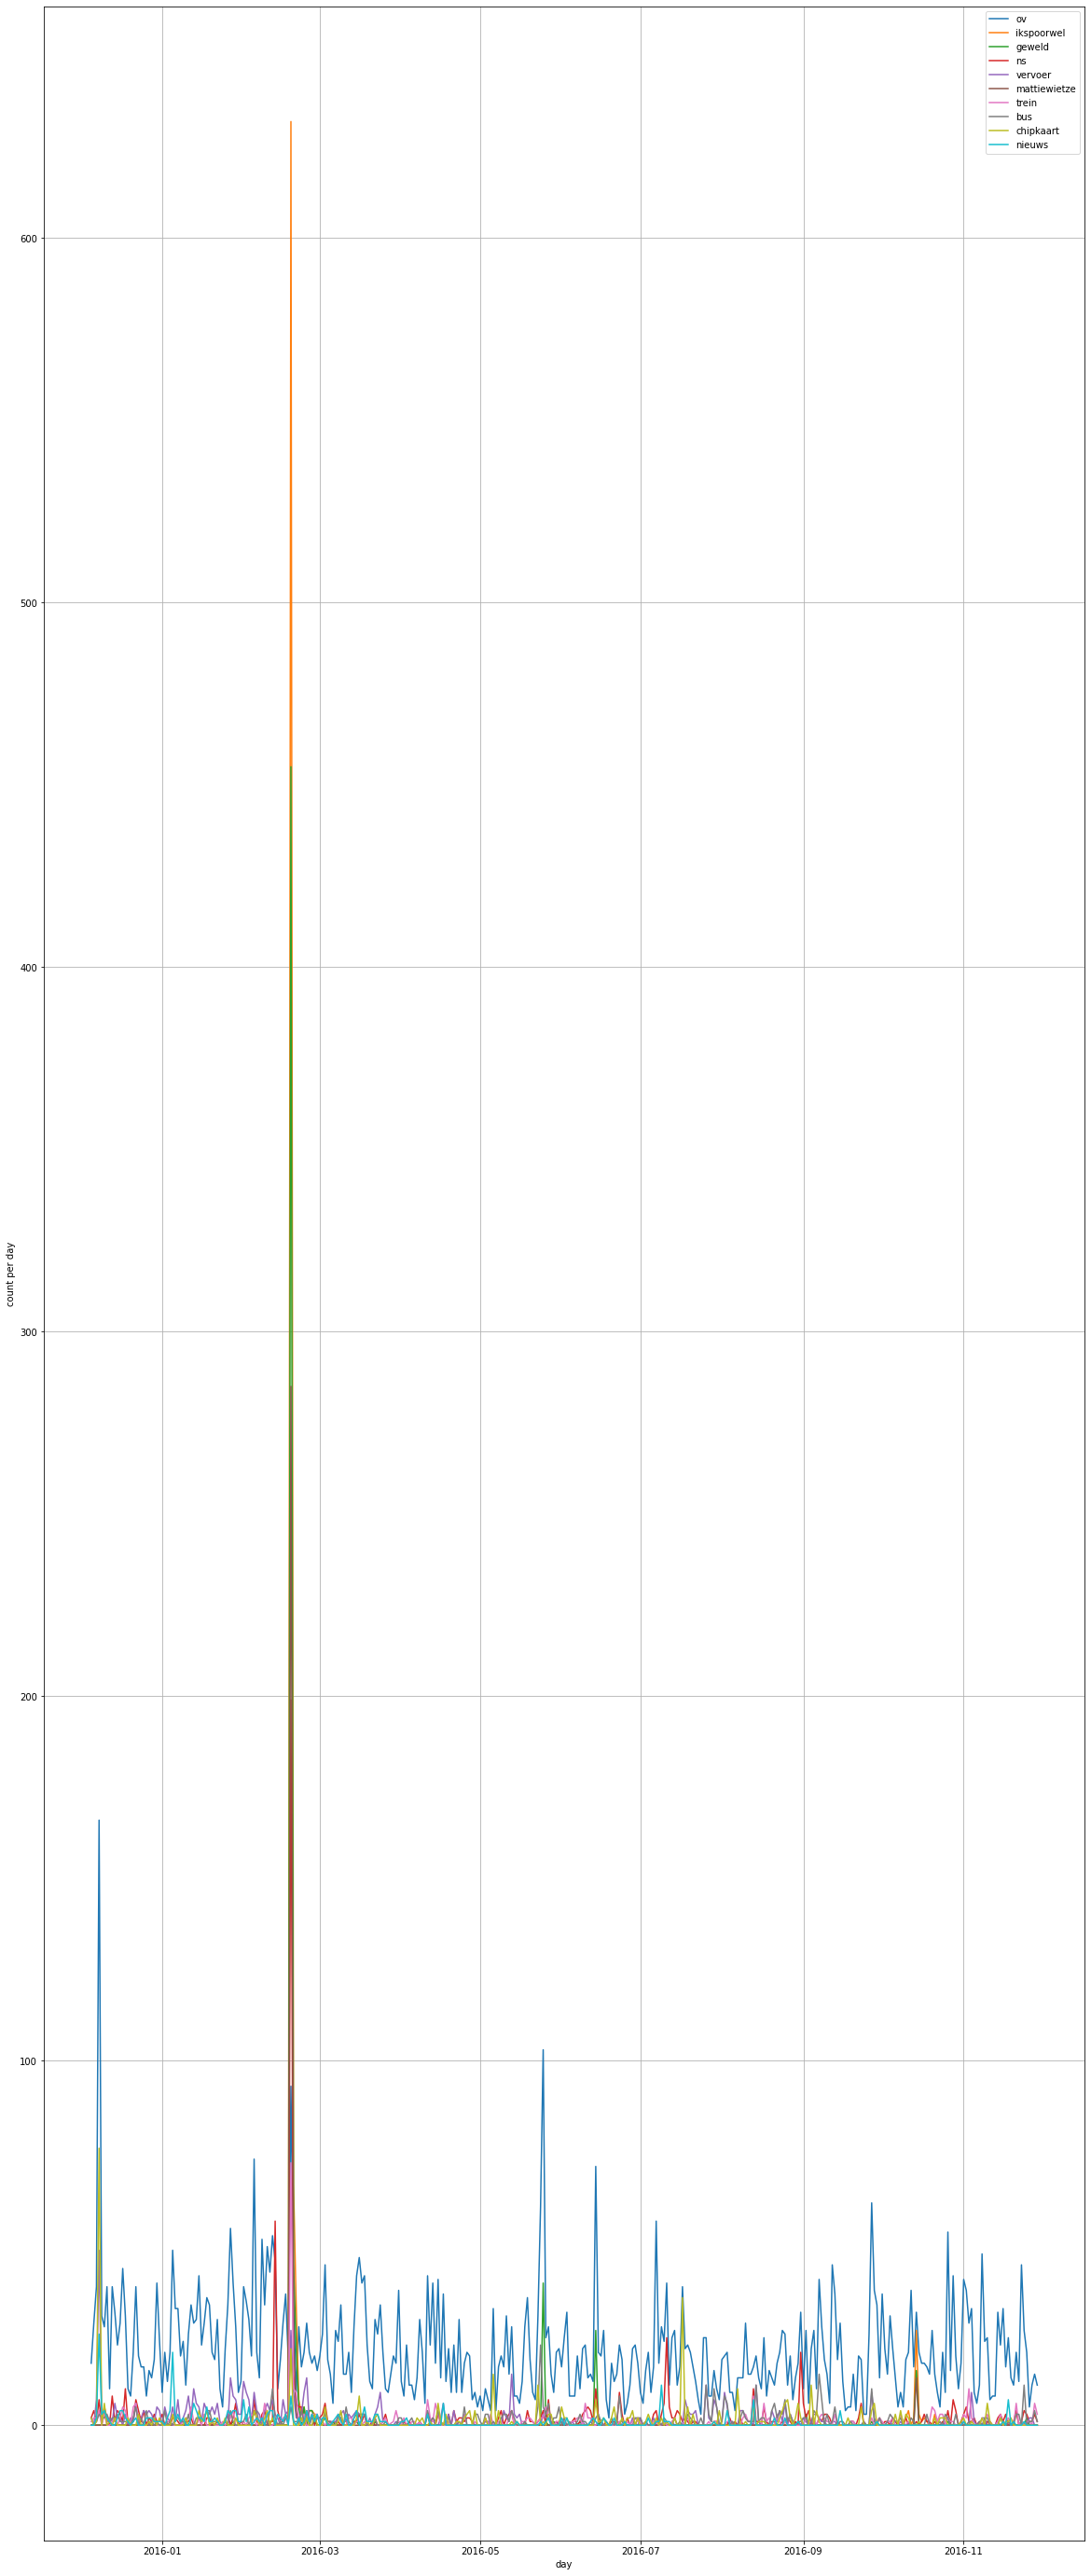

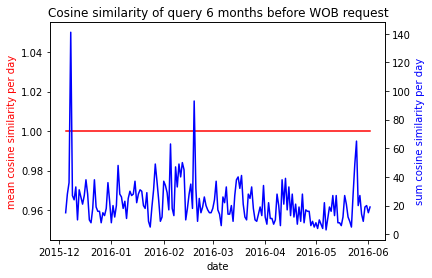

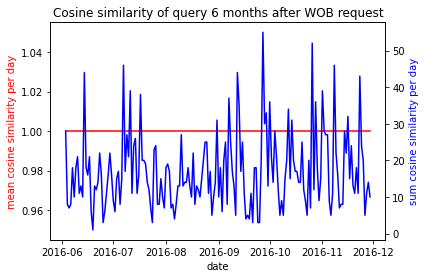

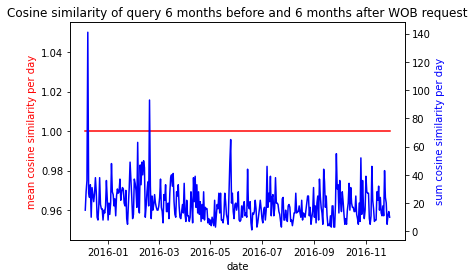

In [306]:
df_ov = pd.read_json("/Users/immelieve/Desktop/UNI/Bachelor/Bachelor jaar 4/Scriptie/Code/tweets_wob/imme_json/tag_ov.json", lines=True)
df_ikspoorwel = pd.read_json("/Users/immelieve/Desktop/UNI/Bachelor/Bachelor jaar 4/Scriptie/Code/tweets_wob/imme_json/tag_ikspoorwel.json", lines=True)
df_ov_ikspoorwel = combine_two_dataframes(df_ov, df_ikspoorwel, ['text','created_at'])
df_before, df_after, docs_before, docs_after, values_before, values_after = get_tweet_count_plots(df_ov_ikspoorwel,'2016-06-02', 6, 100, stopwords, "ov and/or ikspoorwel")
group_day_before, group_day_before, group_day_all = get_word_count_plot(df_before, df_after, docs_before, docs_after, values_before, 10, 0)
query = "beleid inzake geweldincidenten en meldingen betreffende geweldincidenten tegen OV-personeel"
cosine_plot = plot_cosine_sim(query, df_before, df_after, docs_before, docs_after)

In [305]:
# Print the amount of tweets in each dataframe
print("Amount of tweets using #covra: " + str(len(df_covra)))
print("Amount of tweets using #tenderned and/or #aanbesteding: " + str(len(dt_aanbesteding_tenderned)))
print("Amount of tweets using #digid and/or #logius: " + str(len(dt_logius_digid)))
print("Amount of tweets using #ov and/or #ikspoorwel: " + str(len(df_ov_ikspoorwel)))
print("Amount of tweets using #slachthuis: " + str(len(df_slachthuis)))
print("Amount of tweets using #mh17 and/or #vliegveiligheid: " + str(len(df_vliegveiligheid_mh17)))


Amount of tweets using #covra: 342
Amount of tweets using #tenderned and/or #aanbesteding: 16602
Amount of tweets using #digid and/or #logius: 16551
Amount of tweets using #ov and/or #ikspoorwel: 234067
Amount of tweets using #slachthuis: 4473
Amount of tweets using #mh17 and/or #vliegveiligheid: 497039
